# Predicting Back orders in Supply Chain Management
#### Author: Ishika Narang
#### Master in Analytics and AI, 2027
#### Individual Take-Home Assignment, Introduction to Machine Learning

<div class="alert alert-block alert-info">

## 1. Introduction and business context

In supply chain management, "backorders" occur when an order cannot be completed at the point of sale due to the item not being in the seller's inventory, even though it is still being produced or accessible from the distributor. Backorders indicate to the seller that anticipated demand has surpassed expectations, whether due to inadequate planning, supply chain problems, excessively rigid safety stock policies, or an unexpected surge in demand for a product (Jenkins, 2025).

From a business perspective, backorders damage a company's performance on several fronts, such as:
* **Customer dissatisfaction** - late or incomplete deliveries erode customer trust and encourage customers to switch to competitors.
* **Revenue delays** - and opportunity lost from unfulfilled orders.
* **Operational chaos** - supply managers and staff are forced to switch to reactive mode to expedite shipments, re-allocate scarce stock, renegotiate with suppliers, or even find alternative sources.
* **Hidden cost and risk** - frequent backorders indicate deeper structural issues such as chronic under-forecasting of products, over-reliance on a single or a few suppliers, insufficient safety stock, and stress on staff.
* **Damaged service-level agreements (SLAs)** - An SLA is a formal documented agreement between a service provider (for example, a supplier) and a customer that outlines the specific level and logistics of the service expected (Hand, 2025). SLA violations cause backorders and increase the risk of inventory issues.

For a company managing thousands of stock-keeping units (SKUs) across a complex supply network, the question becomes: ***Can we identify which parts are at high risk of going on backorder before it actually happens?*** This is the motivation behind my project.

A good early warning system does not eliminate all the backorders uncertainty but it can give the supply chain managers a critical advantage, which would be the **time to intervene**. When informed of all the high-risk SKUs at regular frequent intervals, they can take targeted actions such as increase safety stock for certain parts, negotiate better deals with suppliers ahead of time, diversify their suppliers, and even do more accurate contingency planning. **This transforms reactive responses to proactive risk management.**

### Framing as a machine learning problem
**Data sourcing:** For this project, I am using the Backorder Prediction Dataset from Kaggle (https://www.kaggle.com/datasets/gowthammiryala/back-order-prediction-dataset/data), which is already split into 2 files - Training_BOP.csv and Testing_BOP.csv. The data is tabular and concerns spare parts in a supply chain. Each row is a snapshot of an SKU with features describing its inventory, demand and supplier performance (explored in detail below). The datacard on Kaggle does not describe the dataset or the units of the features included, so I will explore the data in detail and clearly state the assumptions I would make to use the data.

**Overall Goal:** Considering the business value of the early-warning system, I will treat this as a classification task where my model is less about being perfectly “right” on every SKU, and more about **surfacing a set of high-risk parts where early intervention has the biggest impact**.

### Goal of the project
Design a computational essay that:
* Frames the business problem as an ML problem clearly
* Builds a reproducible and transparent ML pipeline
* Compares multiple ML algorithms and evaluates them with the appropriate data considerations
* Integrates explainable AI to understand feature contributions to backorder risk
* Translates model results into business recommendations

By the end of the pipeline, a supply chain manager should be able to identify which and what kind of SKUs are systematically at risk of a backorder and what levers drive the risk.

P.S - yellow boxes are for interpretation, blue boxes are for explaining approach 

In [4]:
# Set up: libraries, plotting, data

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math
import warnings
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import shap
warnings.filterwarnings('ignore') # to suppress warnings for cleaner output

# configuring plotting aesthetics
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# for readability
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

print('libraries imported')

# now loading data
df_train = pd.read_csv('data/Training_BOP.csv')
df_test = pd.read_csv('data/Testing_BOP.csv')

libraries imported


<div class="alert alert-block alert-info">

## 2. EDA
**Basic data overview:**


In [5]:
print('Training data shape:', df_train.shape)
print('Testing data shape:', df_test.shape)

print('First few rows:', '\n', df_train.head())
print('Training data columns:', df_train.columns)


Training data shape: (1687861, 23)
Testing data shape: (242076, 23)
First few rows: 
        sku  national_inv  lead_time  in_transit_qty  forecast_3_month   
0  1026827         0.000        NaN           0.000             0.000  \
1  1043384         2.000      9.000           0.000             0.000   
2  1043696         2.000        NaN           0.000             0.000   
3  1043852         7.000      8.000           0.000             0.000   
4  1044048         8.000        NaN           0.000             0.000   

   forecast_6_month  forecast_9_month  sales_1_month  sales_3_month   
0             0.000             0.000          0.000          0.000  \
1             0.000             0.000          0.000          0.000   
2             0.000             0.000          0.000          0.000   
3             0.000             0.000          0.000          0.000   
4             0.000             0.000          0.000          0.000   

   sales_6_month  sales_9_month  min_bank potent

In [6]:
df_train.info()
df_train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1687861 entries, 0 to 1687860
Data columns (total 23 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   sku                1687861 non-null  object 
 1   national_inv       1687860 non-null  float64
 2   lead_time          1586967 non-null  float64
 3   in_transit_qty     1687860 non-null  float64
 4   forecast_3_month   1687860 non-null  float64
 5   forecast_6_month   1687860 non-null  float64
 6   forecast_9_month   1687860 non-null  float64
 7   sales_1_month      1687860 non-null  float64
 8   sales_3_month      1687860 non-null  float64
 9   sales_6_month      1687860 non-null  float64
 10  sales_9_month      1687860 non-null  float64
 11  min_bank           1687860 non-null  float64
 12  potential_issue    1687860 non-null  object 
 13  pieces_past_due    1687860 non-null  float64
 14  perf_6_month_avg   1687860 non-null  float64
 15  perf_12_month_avg  1687860 non-n

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty
count,1687860.000,1586967.000,1687860.000,1687860.000,1687860.000,1687860.000,1687860.000,1687860.000,1687860.000,1687860.000,1687860.000,1687860.000,1687860.000,1687860.000,1687860.000
mean,496.112,7.872,44.052,178.119,344.987,506.364,55.926,175.026,341.729,525.270,52.772,2.044,-6.872,-6.438,0.626
std,29615.234,7.056,1342.742,5026.553,9795.152,14378.924,1928.196,5192.378,9613.167,14838.614,1254.983,236.016,26.556,25.843,33.722
min,-27256.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-99.000,-99.000,0.000
25%,4.000,4.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.630,0.660,0.000
50%,15.000,8.000,0.000,0.000,0.000,0.000,0.000,1.000,2.000,4.000,0.000,0.000,0.820,0.810,0.000
75%,80.000,9.000,0.000,4.000,12.000,20.000,4.000,15.000,31.000,47.000,3.000,0.000,0.970,0.950,0.000
max,12334404.000,52.000,489408.000,1427612.000,2461360.000,3777304.000,741774.000,1105478.000,2146625.000,3205172.000,313319.000,146496.000,1.000,1.000,12530.000


<div class="alert alert-block alert-warning">

The dataset contains **more than 1.6 million rows and 23 features**. This is a big and rich dataset which should provide a good foundation for training complex models.

**Data columns**

* sku: identifier for the part 
* national_inv: current inventory level
* lead_time: supplier lead time, i.e. total duration from when a buyer places an order with a supplier until the goods are received, encompassing order processing, production, packaging, and shipping   (Aligni, 2025)
* in_transit_qty: quantity of items currently in transit
* forecast_3_month, forecast_6_month, forecast_9_month: forecasted demand
* sales_1_month, sales_3_month, sales_6_month, sales_9_month: historical sales volume
* min_bank: minimum recommended stock level
* potential_issue: Yes/No flag for known issues with the item
* pieces_past_due: quantity overdue from supplier
* perf_6_month_avg, perf_12_month_avg: supplier performance metrics
* local_bo_qty: local backorder quantity / overdue orders
* deck_risk, oe_constraint, ppap_risk, stop_auto_buy, rev_stop: additional Yes/No risk & constraint flags
* went_on_backorder: target (Yes/No) – whether the SKU went on backorder
* validation: (0/1/2) indicator for train/validation/test split in the original Kaggle formulation


**Looking at the data, I can segregate the features into the following categories to understand them better:**

- `sku`: string identifier for the part
- Numerical signals around inventory and demand:
  - `national_inv`, `in_transit_qty`, `min_bank`
  - `forecast_3_month`, `forecast_6_month`, `forecast_9_month`
  - `sales_1_month`, `sales_3_month`, `sales_6_month`, `sales_9_month`
- Supplier and performance-related fields:
  - `lead_time`, `pieces_past_due`
  - `perf_6_month_avg`, `perf_12_month_avg`, `local_bo_qty`
- Binary / flag-like variables (stored as "Yes"/"No" strings):
  - `potential_issue`, `deck_risk`, `oe_constraint`,
    `ppap_risk`, `stop_auto_buy`, `rev_stop`
- Target:
  - `went_on_backorder` – "Yes"/"No" 

**At this stage I am not changing anything yet, I will first gather a better picture of the raw data and then make the data decisions accordingly.**

</div>

<div class="alert alert-block alert-info">

### 2.1 **Understanding individual features**

On manual inspection, I found that the data contains too many zeros, some odd outlier-like values and value of -99 is prevalent  (-99 is used as a placeholder for missing data). Thus, I will explore the individual behaviour of the main numerical and categorical features to understand:

- Typical scales and units (since the Kaggle card does not specify them).
- Features with suspicious patterns, such as a high number of zeros or odd placeholder values.
- Missingness patterns that may later require imputation or conversion to proper NaNs.
- Whether the available ranges make sense from a supply-chain point of view (this will be confirmed with research, cited in the bibliography).

*This will inform my preprocessing, which features require transformation, whether engineered features such as ratios are needed, and which features might violate an early-warning principle.*

In [7]:
quality_summary = []

for col in df_train.columns:
    if col == "went_on_backorder":
        continue
    series = df_train[col]
    summary = {
        "feature": col,
        "dtype": series.dtype,
        "missing_count": series.isna().sum(),
        "zero_count": (series == 0).sum() if pd.api.types.is_numeric_dtype(series) else np.nan,
        "negative_count": (series < 0).sum() if pd.api.types.is_numeric_dtype(series) else np.nan,
        "unique_values": series.nunique(),
        "min": series.min() if pd.api.types.is_numeric_dtype(series) else None,
        "max": series.max() if pd.api.types.is_numeric_dtype(series) else None
    }
    # detect -99 placeholders
    if pd.api.types.is_numeric_dtype(series):
        summary["contains_-99"] = (-99 in series.values)
        summary["percent_-99"] = (series == -99).mean() * 100
    quality_summary.append(summary)

quality_df = pd.DataFrame(quality_summary)
quality_df.sort_values("missing_count", ascending=False)


,feature,dtype,missing_count,zero_count,negative_count,unique_values,min,max,contains_-99,percent_-99
2,lead_time,float64,100894,10511.000,0.000,32,0.000,52.000,False,0.000
11,min_bank,float64,1,872331.000,0.000,5568,0.000,313319.000,False,0.000
12,potential_issue,object,1,NaN,NaN,2,NaN,NaN,NaN,NaN
20,stop_auto_buy,object,1,NaN,NaN,2,NaN,NaN,NaN,NaN
19,ppap_risk,object,1,NaN,NaN,2,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
6,forecast_9_month,float64,1,1033241.000,0.000,13662,0.000,3777304.000,False,0.000
5,forecast_6_month,float64,1,1084111.000,0.000,11114,0.000,2461360.000,False,0.000
4,forecast_3_month,float64,1,1177722.000,0.000,7825,0.000,1427612.000,False,0.000
3,in_transit_qty,float64,1,1344662.000,0.000,5230,0.000,489408.000,False,0.000


<div class="alert alert-block alert-warning">

**Interpretation:**
* **lead time**: Missing for 100894 rows which is substantial. Zero values of 10511 rows also exist. Lead time of 0 days is operationally not possible so this value is probably indicates failure of recording a lead time. However, this feature is very important in the prediction so it must be correctly handled.
    * **Inferred unit: Range of 0–52 strongly suggests days**.
* **forecast_, sales_ variables:** Approximately 90% of values are 0s for sales and forecasts across 3, 6, 9 months. Given that spare parts demand often consists of many periods with no demand at all (Syntetos et al., 2012), this could be considered typical behavior. Distributions are also highly right-skewed, with a small number of extremely high-volume SKUs dominating the tail.
    * **Inferred unit: These values behave like unit counts per planning window (monthly, quarterly).
Nothing suggests they represent monetary values or standardized metrics.**
* **national_inv (current inventory)**: Contains significant amount of 0s and negative values confirming the presence of backlogged orders recorded as negative stock. The very heavy right tail (max > 12 million) points to a few sku's with enormous stock levels (possibly bulk supply materials or components with long supply cycles). Here, the negative values must not be removed as they are genuine values.
* **Performance Metrics (perf_6_month_avg, perf_12_month_avg)** - Both contain –99 values for ~7% of rows. The value -99 in supply data typically serves as a code for missing, irrelevant, or undefined data. The valid range is 0.0 to 1.0, acting as a reliability score (for example in supplier on-time performance ratio). (SourceDayTeam, 2025)
    * I can replace -99 with NaN, add a binary indicator called 'perf_missing_flag'and then either impute using median or leave missing values as is (tree models can handle missingness directly).
* **pieces_past_due (quantity overdue from supplier), local_bo_qty (overdue orders)** - Both have extremely high numbers of 0s. These features are very informative, but depending on when the snapshot is taken, they may capture the backorder event already unfolding. **This raises a question of data leakage for an early-warning model that I must address.**
    * My goal is to build a realistic early-warning model, thus I have to *exclude these features* since the Kaggle card does not mention the time of the data recorded and including these could heavily bias the model results


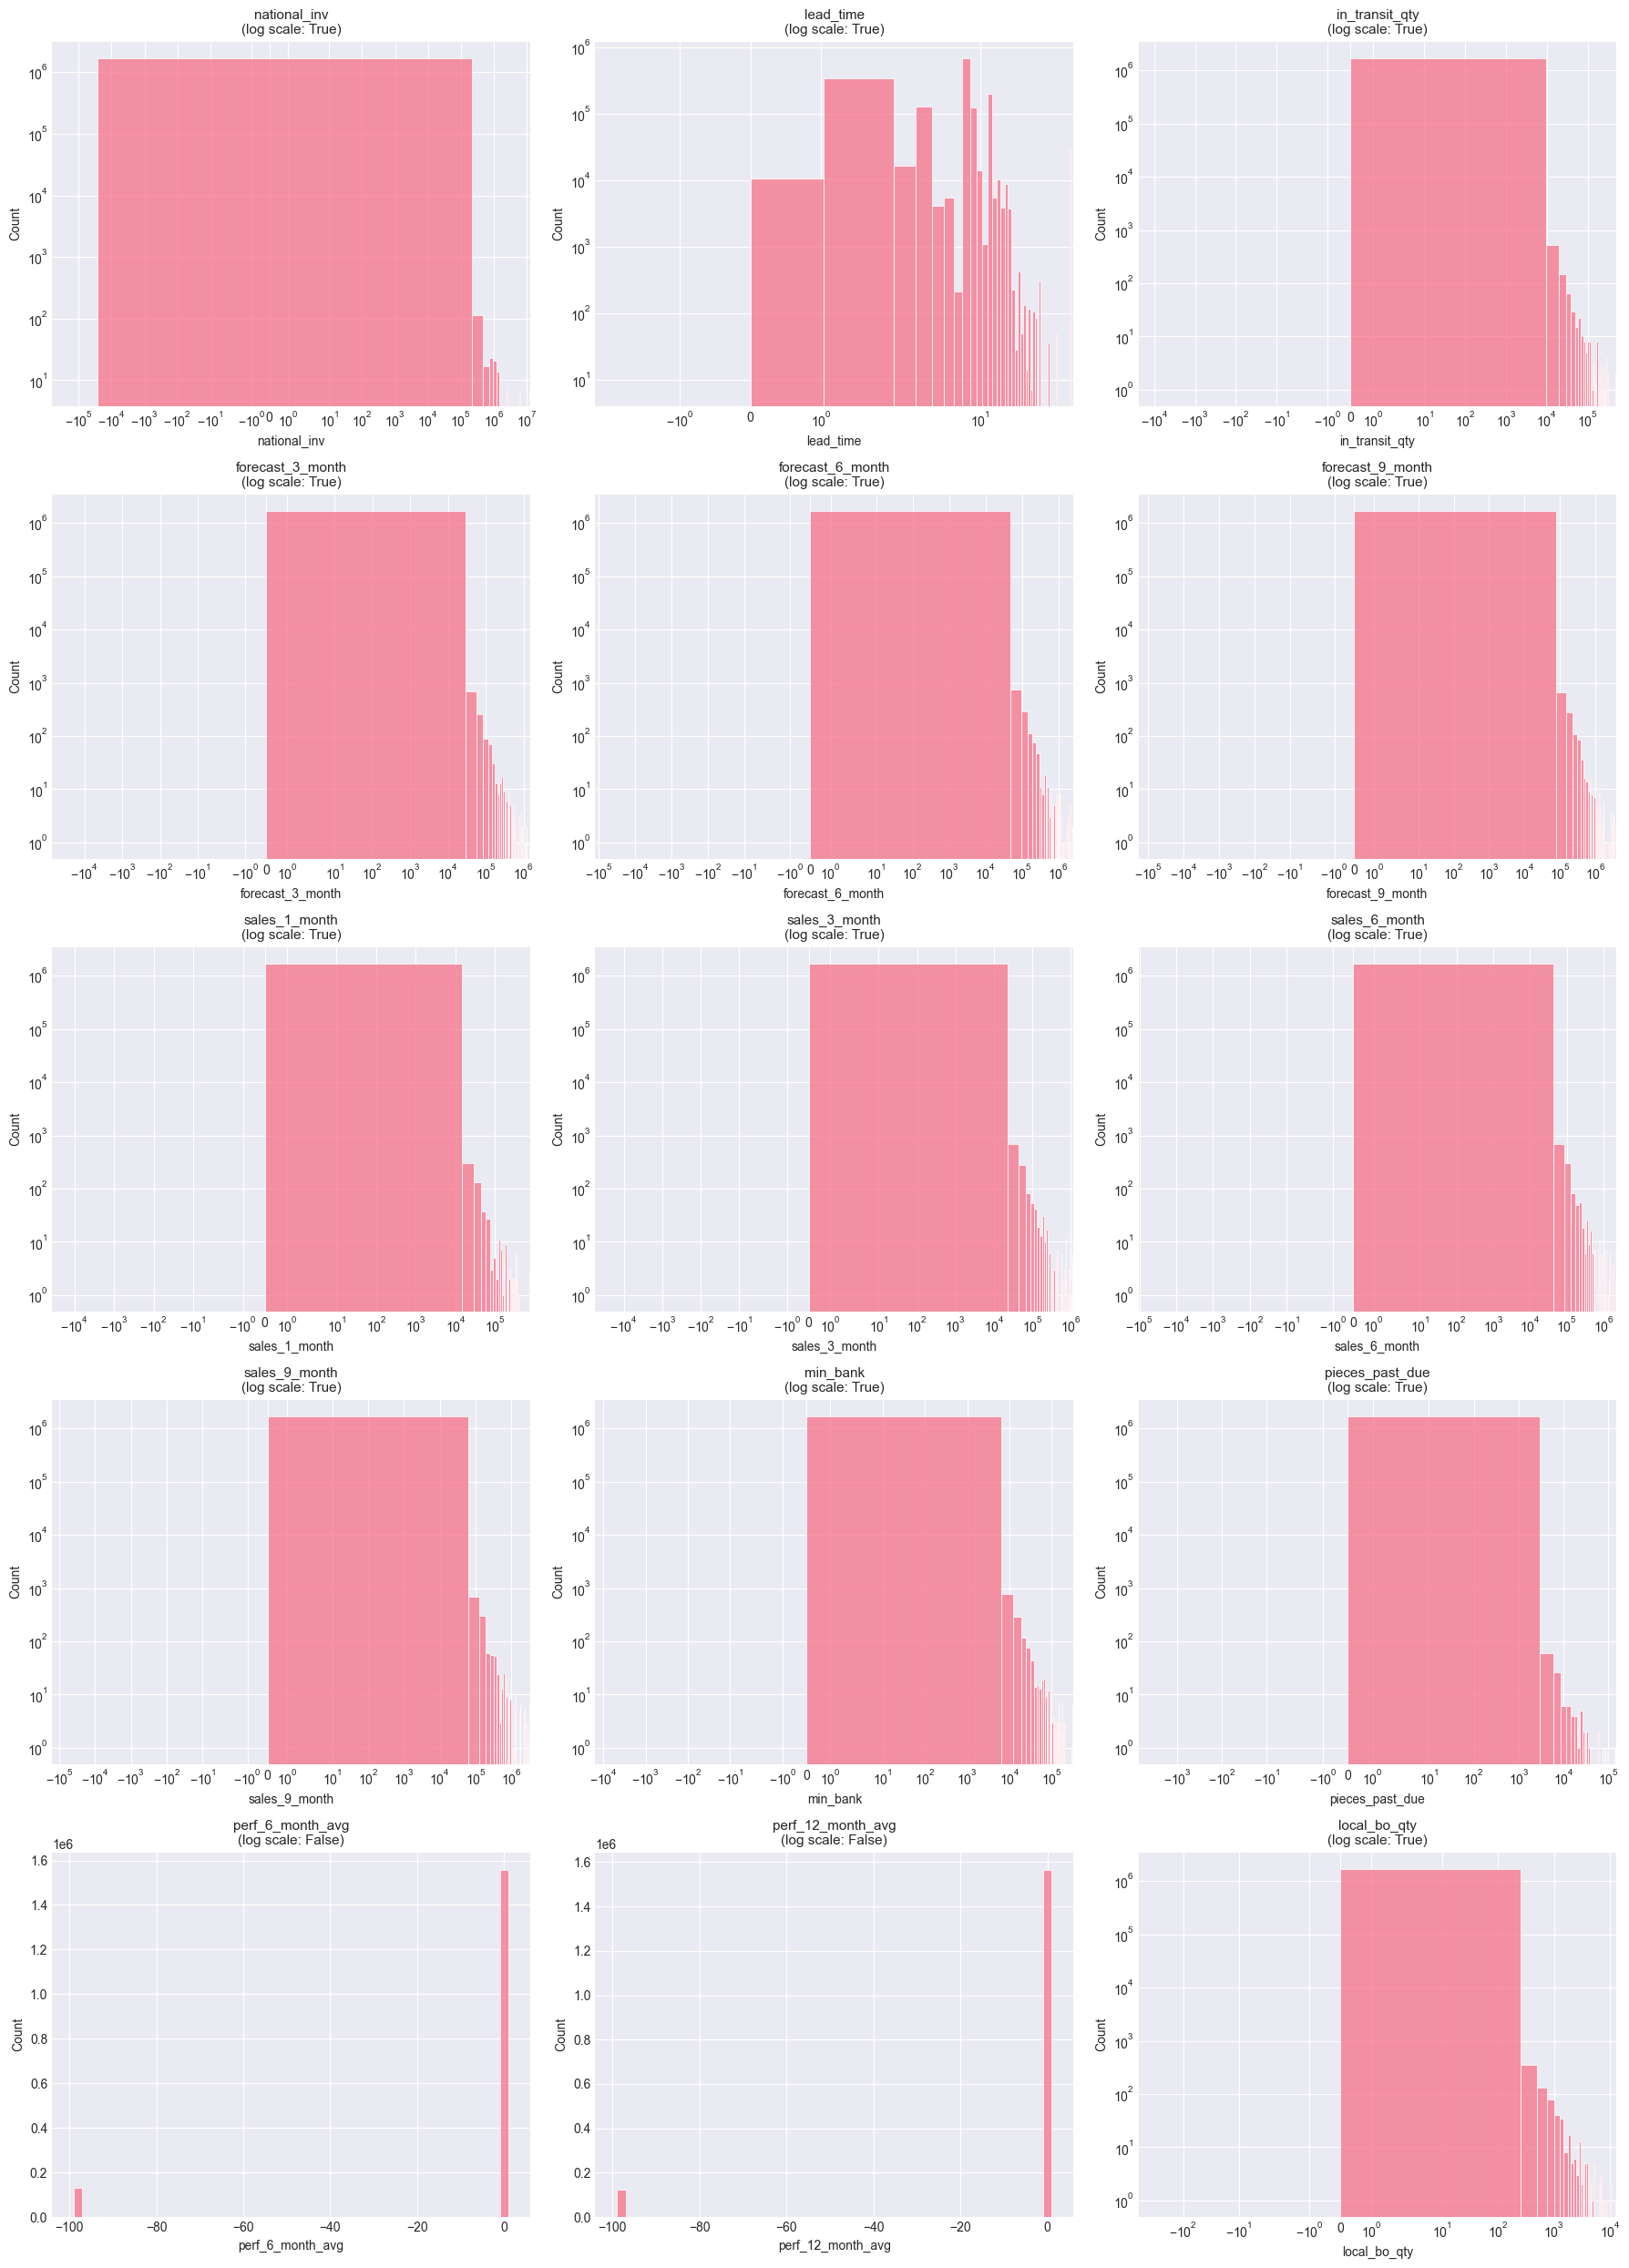

In [8]:
numeric_cols = df_train.select_dtypes(include=[np.number]).columns.tolist() # numeric columns

n_cols = 3  # plots per row
n_rows = math.ceil(len(numeric_cols) / n_cols) # grid layout

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten() # make indexing easier

for i, col in enumerate(numeric_cols):
    ax = axes[i]
    # log for skewness
    skew = df_train[col].skew()
    use_log = skew > 3

    sns.histplot(df_train[col], bins=50, ax=ax)
    ax.set_title(f"{col}\n(log scale: {use_log})", fontsize=11)

    if use_log:
        ax.set_xscale("symlog")
        ax.set_yscale("log")

    ax.set_xlabel(col)
    ax.set_ylabel("Count")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j]) # remove any empty subplots

plt.tight_layout()
plt.show()

<div class="alert alert-block alert-warning">

**The histograms revealed more about the way the supply chain and inventory orders are managed :**
* **national_inv** - distribution is extremely right-skewed, with most SKUs holding very low inventory and a small number carrying very large stock levels
* **lead_time** - concentrated in a narrow range (roughly 4–12), with a long right tail extending to higher values. This suggests most suppliers are relatively fast, but a subset of SKUs faces significantly longer replenishment delays.
* **in_transit_qty** - Most SKUs have 0 items in transit at the snapshot, while a small fraction shows very large pipeline quantities. **This indicates episodic replenishment behavior rather than continuous ordering.**
* **forecast_X_month (3,6,9)**- Forecasted demand is highly right-skewed with a large mass at zero, reflecting intermittent demand typical of spare parts.
* **sales_X_month (1,3,6,9)** - Sales exhibit classic intermittent demand behavior of many periods with zero sales and occasional large spikes. This confirms that raw sales volumes alone are noisy predictors without additional context.
* **min_bank** - Minimum recommended stock levels are zero for most SKUs, with a long tail for critical or high-volume items. This suggests differentiated inventory policies across SKUs rather than a uniform safety-stock rule.
* **pieces_past_due** - The distribution is dominated by zeros, with a small number of SKUs showing large overdue quantities.
* **local_bo_qty** - Almost all observations are zero, but the long right tail indicates that once backorders occur, they can accumulate rapidly. This variable is likely highly predictive but may encode late-stage information.
* **perf_6_month_avg** - 2 distinct modes appear:
    * a valid performance range between 0 and 1,
    * a spike at –99 indicating missing or undefined supplier performance.
* **perf_12_month_avg** - mirrors the 6-month metric. Longer-term supplier performance appears stable when available.

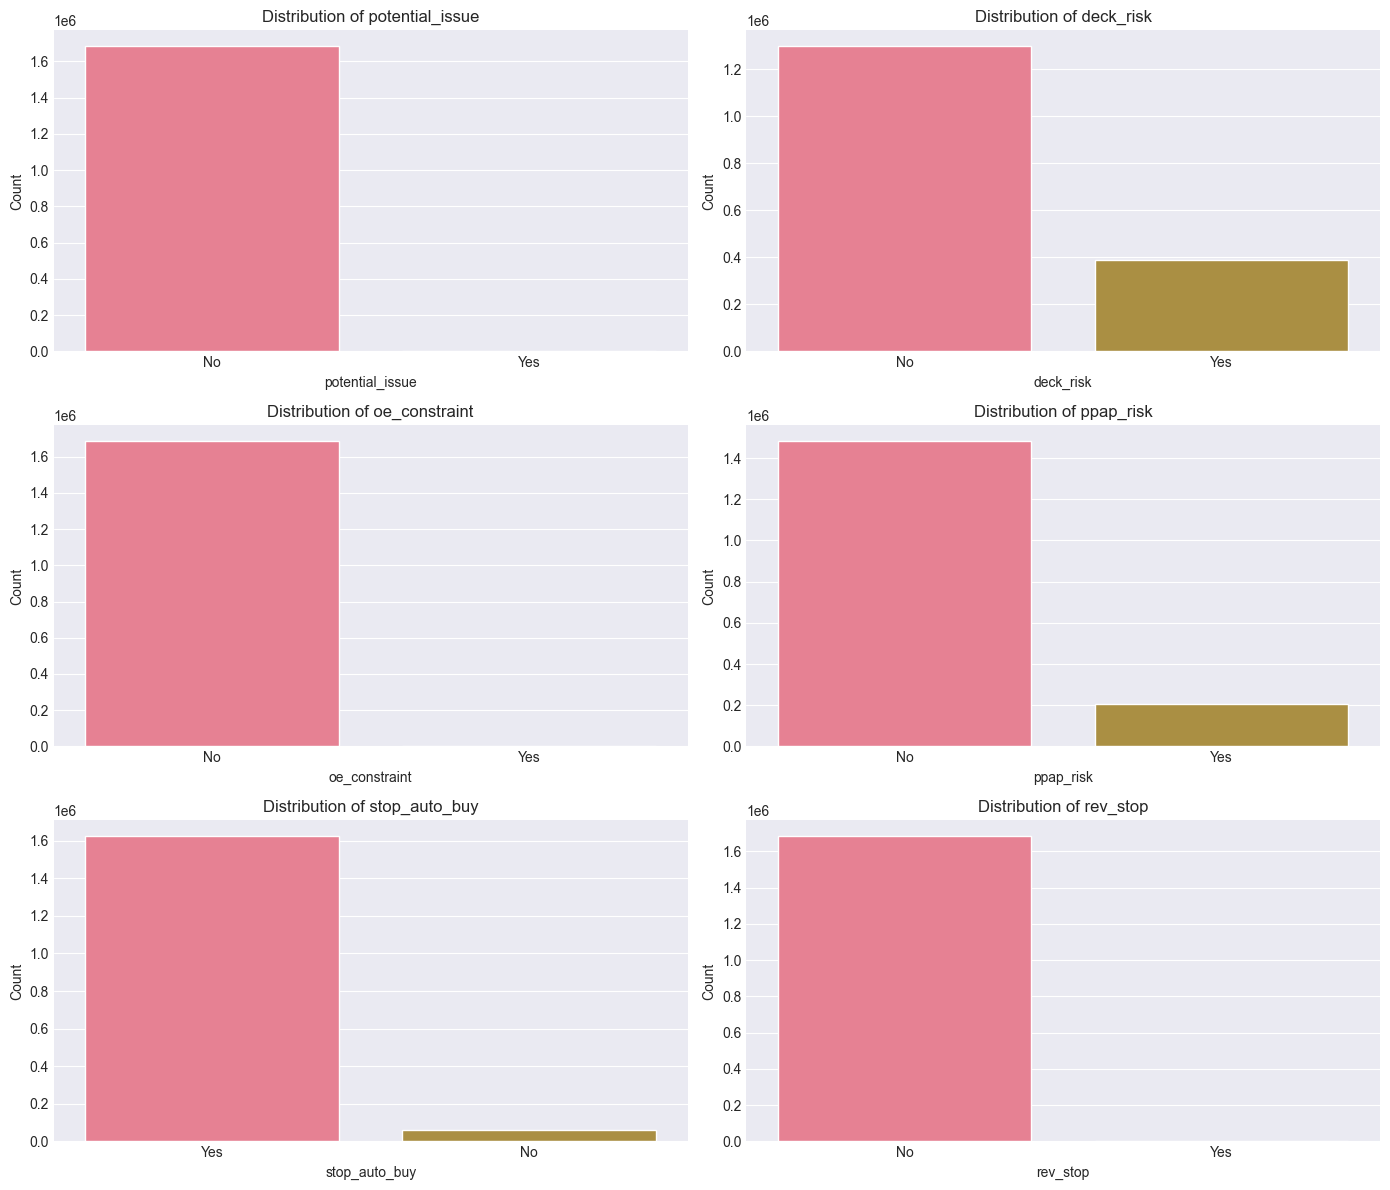

In [9]:
# bar plots for categorical variables
cat_cols = [c for c in df_train.columns if df_train[c].dtype == "object" and c not in ["went_on_backorder", "sku"]]

n_cols = 2
n_rows = math.ceil(len(cat_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    ax = axes[i]
    sns.countplot(data=df_train, x=col, ax=ax)
    ax.set_title(f"Distribution of {col}", fontsize=12)
    ax.set_xlabel(col)
    ax.set_ylabel("Count")

plt.tight_layout()
plt.show()

<div class="alert alert-block alert-warning">

**Similarly, I can make understand the categorical variables through the bar plot splits shows above:**
* **potential_issue** - a vast majority of SKUs are not flagged with a potential issue
* **deck_risk** - deck_risk is a binary indicator capturing a operational or supplier risk assessment, and it flags parts with elevated risk profiles based on internal or supplier evaluation logic, not directly from sales or inventory counts. The plot shows that most SKUs have no deck risk but smaller subset marked is flagged positive for it.
* **oe_constraint** - Almost all SKUs are marked as “No” meaning that original equipment constraints are rare in the dataset. While infrequent, this flag may signal severe supply rigidity when positive.
* **ppap_risk** - PPAP stands for Production Part Approval Process and it is a formal quality assurance process widely used in automotive and related industries to ensure suppliers can meet production requirements consistently (Foulis, 2021). The plot shows that PPAP risk appears in a small minority of SKUs, consistent with compliance or certification issues affecting only specific parts.
* **stop_auto_buy** - majority of SKUs are marked “Yes,” meaning that automatic purchasing is commonly disabled, this could be a control mechanism. *(variable meaning and implication clarified by ChatGPT)*
* **rev_stop** - Revenue stops mean that a part is not eligible for new purchase orders because of credit issues, contract hold, or negative commercial conditions. It signals the non-inventory risk that can contribute to backorders.  Nearly all SKUs are marked “No,” meaning revenue-related stops are extremely rare.  *(variable meaning and implication clarified by ChatGPT)*

<div class="alert alert-block alert-info">

**Assumptions made about the data based on the analysis:**  A critical question in any predictive system is *"at what moment in time is the prediction made and what information is used to make it?"* Thus, for this project, I will make the following conceptual assumptions:
* demand for many SKUs is **intermittent**, meaning that long stretches of zero demand are common and not indicative of data quality issues (Syntetos et al., 2012).
* Extremely skewed distributions (inventory, demand, pipeline quantities) reflect **real
   operational heterogeneity** across SKUs, not measurement error.
* each row in the dataset is a snapshot at time **t**, taken before it is known that a future backorder will occur for an SKU
* the feature `went_on_backorder` from the dataset is what happened *after time t*
* the features I use for the prediction are available at or before time t.
This matters because some variables are “too close” to the event and may encode information that would only be known **once the backorder is already unfolding**. From the analysis above those variables are:
    - `local_bo_qty` – local backorder quantity or overdue orders;
    - `pieces_past_due` – quantities already overdue from the supplier.
    - Thus, I will **exclude** these features that directly encode “the problem is already here”, and use only information that a planner could reasonably see **before** the backorder materialises.
* Risk flags (`potential_issue`, `deck_risk`, `ppap_risk`, `rev_stop`) represent **qualitative
   operational or supplier assessments**, applied selectively rather than uniformly.

<div class="alert alert-block alert-warning">

**Since the Kaggle dataset does not provide a data dictionary, I must rely on values & ranges of the features in the data, and typical supply-chain conventions to interpret. I will make these assumptions explicit so that they can be challenged if needed.**

#### Inferring units of key variables (Based on distributional patterns)
- Inventory and quantity variables (`national_inv`, `in_transit_qty`, `min_bank`,`local_bo_qty`, `pieces_past_due`) are measured in **units (pieces)**.
- Sales and forecast variables represent **units sold or forecasted over the specified time horizon** (1, 3, 6, or 9 months).
- `lead_time` is measured in **days**, consistent with its range and typical supply-chain practice.
- Performance metrics (`perf_6_month_avg`, `perf_12_month_avg`) are **rates between 0 and 1**, with `-99` used as a sentinel value indicating missing or unavailable performance data.
- Binary flags encode **operational or policy states**, not numeric magnitudes.

Making these units explicit will help me later in interpretations and feature engineering choices.

#### Summary of Preprocessing Actions Required
1. lead_time - Impute median and add lead_time_missing.
2. perf_6_month_avg, perf_12_month_avg - Replace –99 with NaN, add perf_missing_flag, and impute median or keep as missing for tree models.
3. Demand & Inventory Variables - Keep zeros as meaningful, log-transform the features.
4. Overdue Variables - Retain, but exclude in early-warning model to avoid leakage.
5. Extreme Outliers - Do not remove as they reflect real supply-chain diversity, but non-linear models will handle these better.

<div class="alert alert-block alert-info">

### 2.2 **Understanding feature and target relationship **

With assumptions clarified, units made explicit, and preprocessing needs identified, I can now move to bivariate exploratory analysis. The goal is to understand how each feature relates to the backorder outcome and to build intuition about which signals are most informative for an early-warning classification model.

This analysis will directly inform feature selection, model choice, and the handling of potential leakage.
First I will do the preprocessing as informed from the analysis above and then get into the bivariate analysis.

In [10]:
# first preprocessing based on above conclusions

df_eda = df_train.copy() # Create a working copy for EDA-based preprocessing

# A) Replace sentinel values (-99) with NaN for supplier performance metrics
perf_cols = ["perf_6_month_avg", "perf_12_month_avg"]

for col in perf_cols:
    df_eda[col] = df_eda[col].replace(-99, np.nan) # -99 converted to missing value

# B) Create a missingness indicator for lead_time
df_eda["lead_time_missing"] = df_eda["lead_time"].isna().astype(int)

# Impute lead_time with median for EDA purposes
df_eda["lead_time"] = df_eda["lead_time"].fillna(df_eda["lead_time"].median())

# C) Identify binary categorical risk flags
risk_flag_cols = [
    "potential_issue",
    "deck_risk",
    "oe_constraint",
    "ppap_risk",
    "stop_auto_buy",
    "rev_stop"
]

# Convert Yes/No to 1/0
for col in risk_flag_cols:
    df_eda[col] = df_eda[col].map({"Yes": 1, "No": 0}) # to simplify comparisons across groups

# D) Encode target variable
df_eda["went_on_backorder"] = df_eda["went_on_backorder"].map({"Yes": 1, "No": 0})


In [11]:
df_eda

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder,lead_time_missing
0,1026827,0.000,8.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,NaN,NaN,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1
1,1043384,2.000,9.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.990,0.990,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0
2,1043696,2.000,8.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,NaN,NaN,0.000,1.000,0.000,0.000,1.000,0.000,0.000,1
3,1043852,7.000,8.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.100,0.130,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0
4,1044048,8.000,8.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,4.000,2.000,0.000,0.000,NaN,NaN,0.000,1.000,0.000,0.000,1.000,0.000,0.000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1687856,1373987,-1.000,8.000,0.000,5.000,7.000,9.000,1.000,3.000,3.000,8.000,0.000,0.000,0.000,NaN,NaN,1.000,0.000,0.000,0.000,1.000,0.000,0.000,1
1687857,1524346,-1.000,9.000,0.000,7.000,9.000,11.000,0.000,8.000,11.000,12.000,0.000,0.000,0.000,0.860,0.840,1.000,1.000,0.000,0.000,0.000,0.000,1.000,0
1687858,1439563,62.000,9.000,16.000,39.000,87.000,126.000,35.000,63.000,153.000,205.000,12.000,0.000,0.000,0.860,0.840,6.000,0.000,0.000,0.000,1.000,0.000,0.000,0
1687859,1502009,19.000,4.000,0.000,0.000,0.000,0.000,2.000,7.000,12.000,20.000,1.000,0.000,0.000,0.730,0.780,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0


<div class="alert alert-block alert-info">

Now that some key issues in the data have been handled, I will use the following approach for my bi-variate analysis:

- **Numeric features vs target:** compare boxplots to see shifts in level/spread and outliers that separate backorders from non-backorders.
- **Binary flags vs target:** compute and plot the **backorder rate** for each flag state to quantify how much each operational risk indicator changes the risk of backordering a product.

#### Numeric vs target boxplots:

In [12]:
# true continuous numeric features
continuous_cols = [
    c for c in df_eda.select_dtypes(include=[np.number]).columns
    if c not in (
        ["went_on_backorder"] +
        risk_flag_cols +  # binary flags
        ["lead_time_missing"]   # binary indicator
    )
]

# drop near-constant columns
continuous_cols = [
    c for c in continuous_cols
    if df_eda[c].nunique() > 5
]

continuous_cols

['national_inv',
 'lead_time',
 'in_transit_qty',
 'forecast_3_month',
 'forecast_6_month',
 'forecast_9_month',
 'sales_1_month',
 'sales_3_month',
 'sales_6_month',
 'sales_9_month',
 'min_bank',
 'pieces_past_due',
 'perf_6_month_avg',
 'perf_12_month_avg',
 'local_bo_qty']

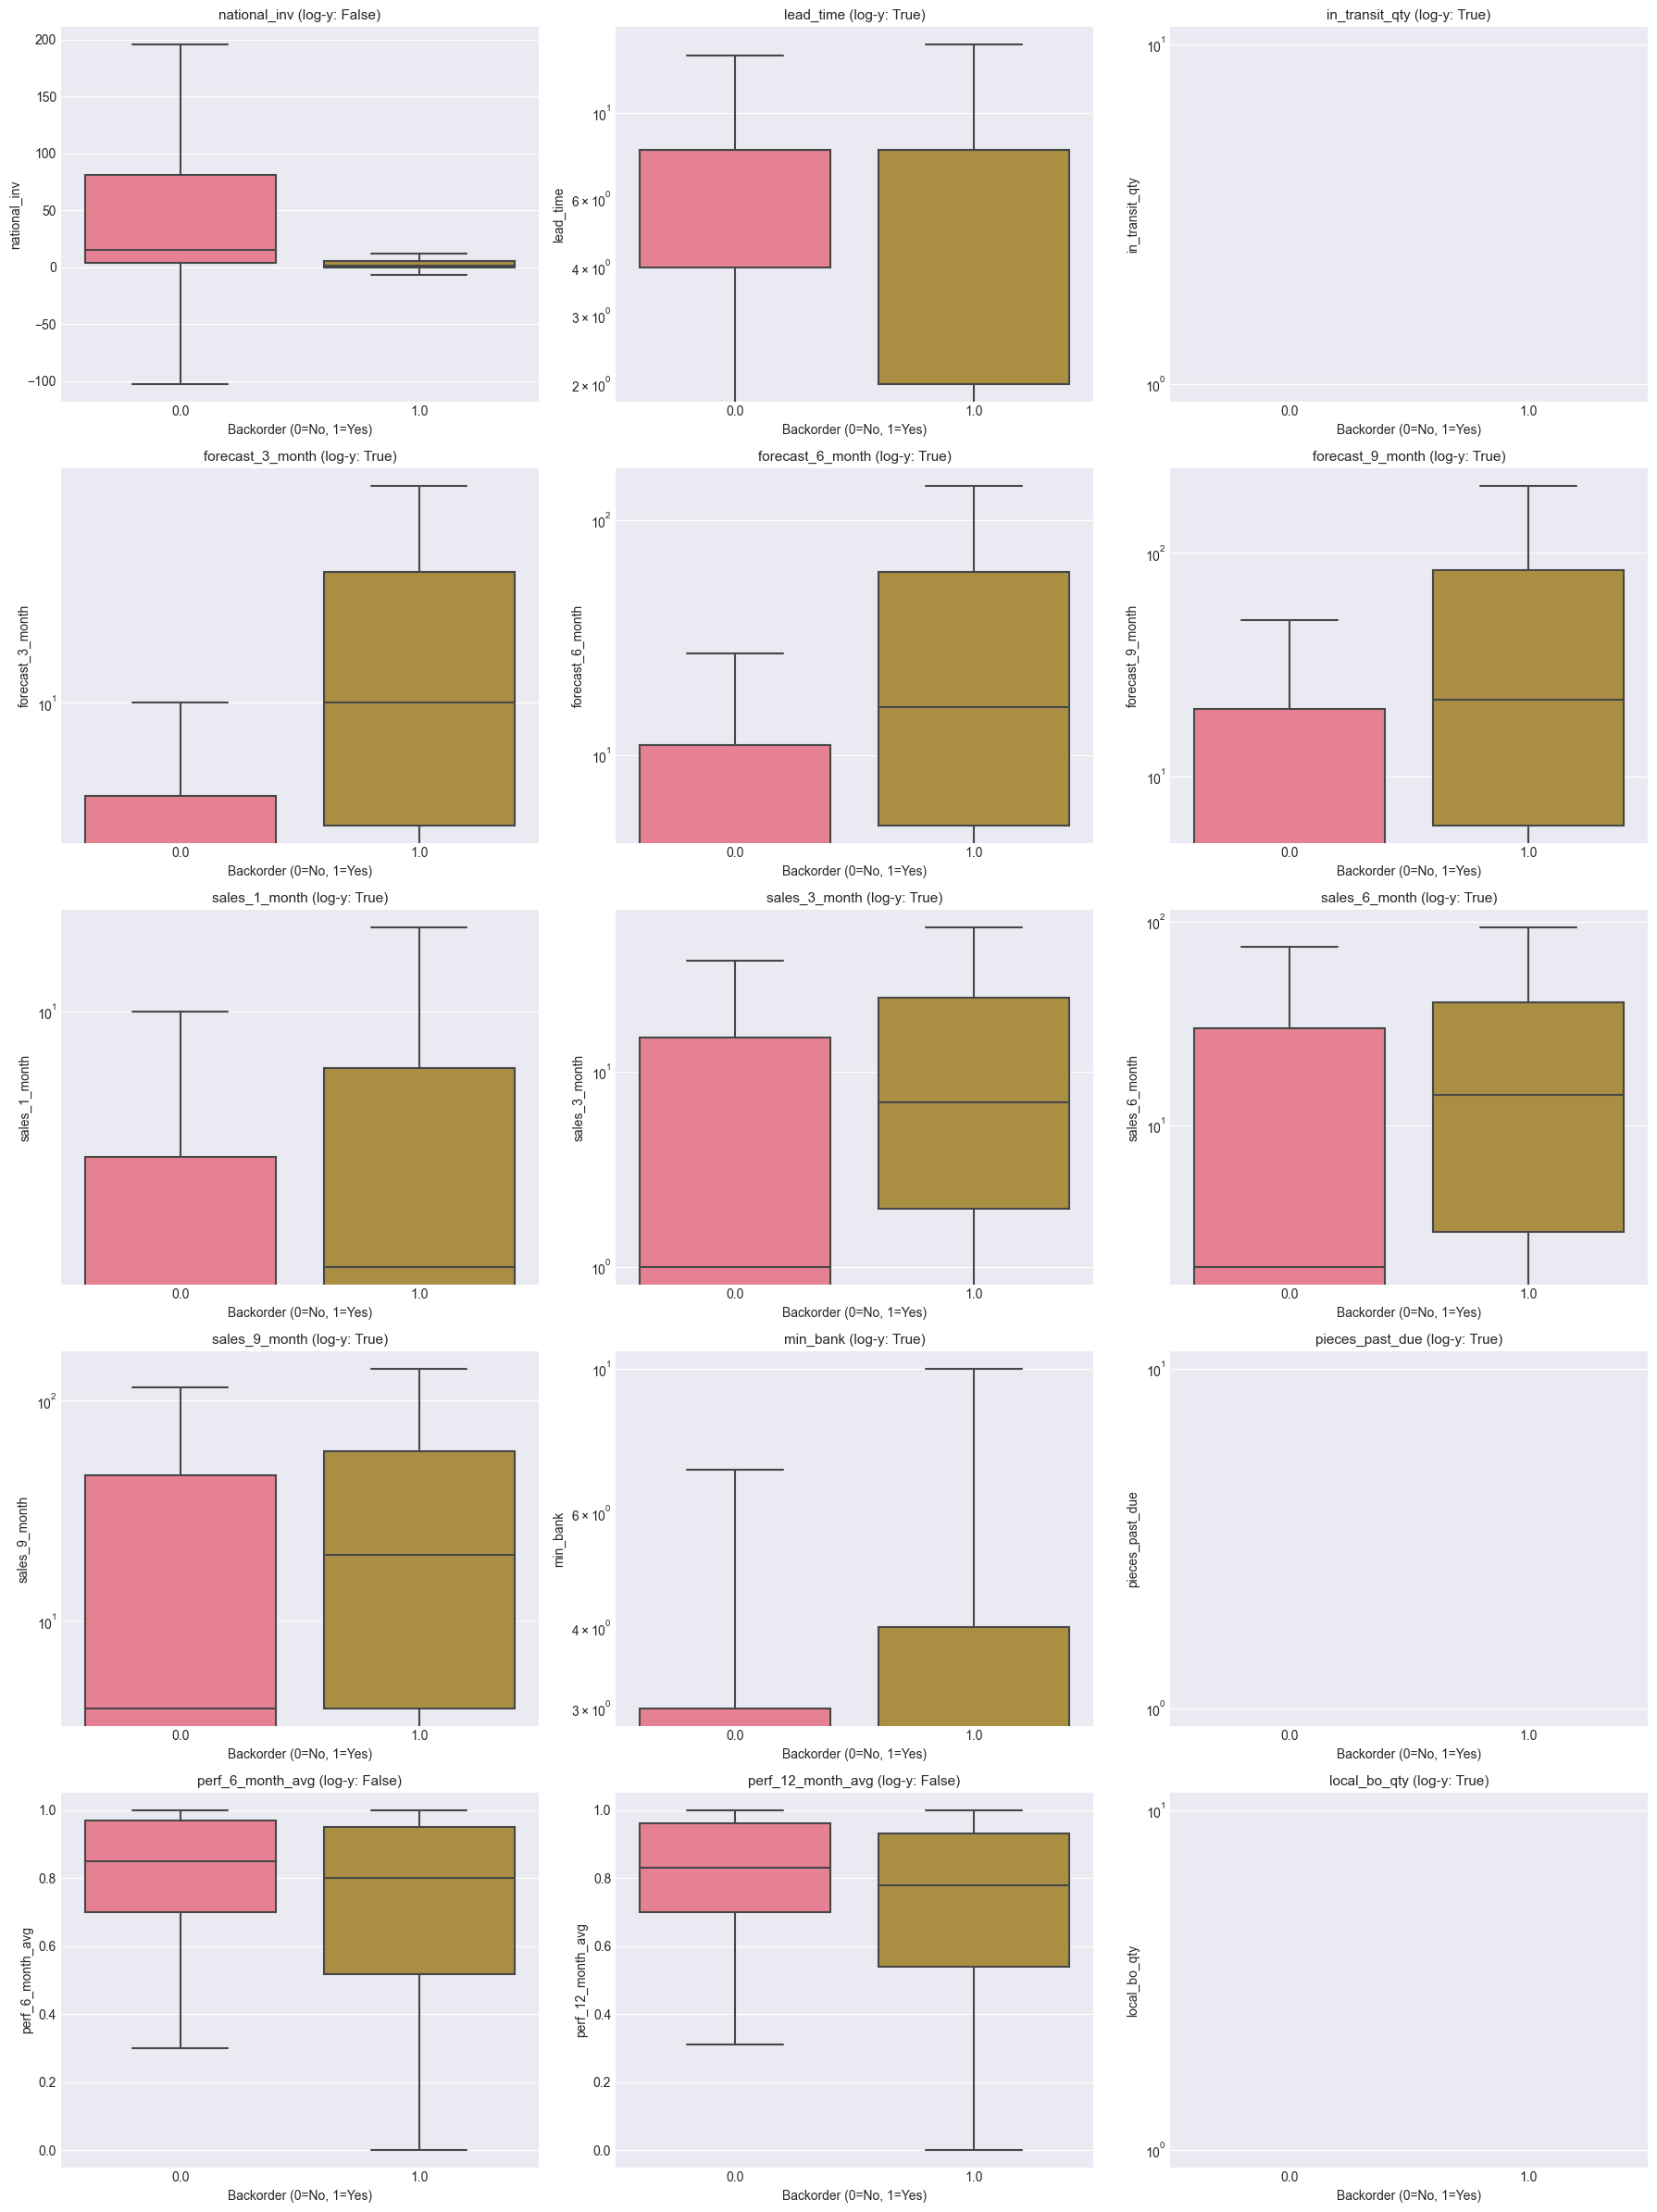

In [13]:
# box plots for numerical features

df_bi = df_eda.sample(60000, random_state=42) # Sample for readability

n_cols = 3
n_rows = math.ceil(len(continuous_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4.8 * n_rows))
axes = axes.flatten()

for i, col in enumerate(continuous_cols):
    ax = axes[i]

    sns.boxplot(
        data=df_bi,
        x="went_on_backorder",
        y=col,
        ax=ax,
        showfliers=False
    )

    skew = df_eda[col].skew()
    use_log = (skew > 3) and (df_eda[col].min() >= 0)

    ax.set_title(f"{col} (log-y: {use_log})", fontsize=11)
    ax.set_xlabel("Backorder (0=No, 1=Yes)")

    if use_log:
        ax.set_yscale("log")

# Remove unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


<div class="alert alert-block alert-warning">

**Interpretation:**
* **national_inv** - Backordered SKUs have significantly lower median inventory levels than non-backordered ones. This aligns with intuition that insufficient on-hand stock is a primary driver of backorders.
* **lead_time** - SKUs that go on backorder tend to have longer lead times and a wider spread
* **forecast_3/6/9_month** - Across all horizons, backordered items show consistently higher forecasted demand. This suggests that rather than random stockouts, demand pressure plays a key role in backorder risk.
* **sales_1/3/6/9_month** - Backordered SKUs exhibit higher historical sales, especially over longer horizons. Sustained demand rather than short-term spikes alone appears to contribute to stockouts.
* **min_bank** - Higher min recommended stock levels are associated with backorders indicating that planners already recognize these SKUs as risky or demand-sensitive items.
* **perf_6_month_avg / perf_12_month_avg** - Backordered SKUs show lower median supplier performance and greater variability. This highlights supplier reliability as an important risk factor.


<div class="alert alert-block alert-info">

#### Risk flags vs target outcome - barplots
To assess how operational risk indicators relate to backorder outcomes, I will create a new metric called **backorder rate** for each binary risk flag. This will be done by **calculating the mean of the binary target variable** (went_on_backorder) for each flag, which would directly represent the proportion of SKUs that eventually went on backorder. The question I am trying to answer using these plots is whether *when a specific operational risk flag is active, does the likelihood of backorder increase?* If I see large differences between the bars then it would mean that the features that may strongly influence backorder risk.

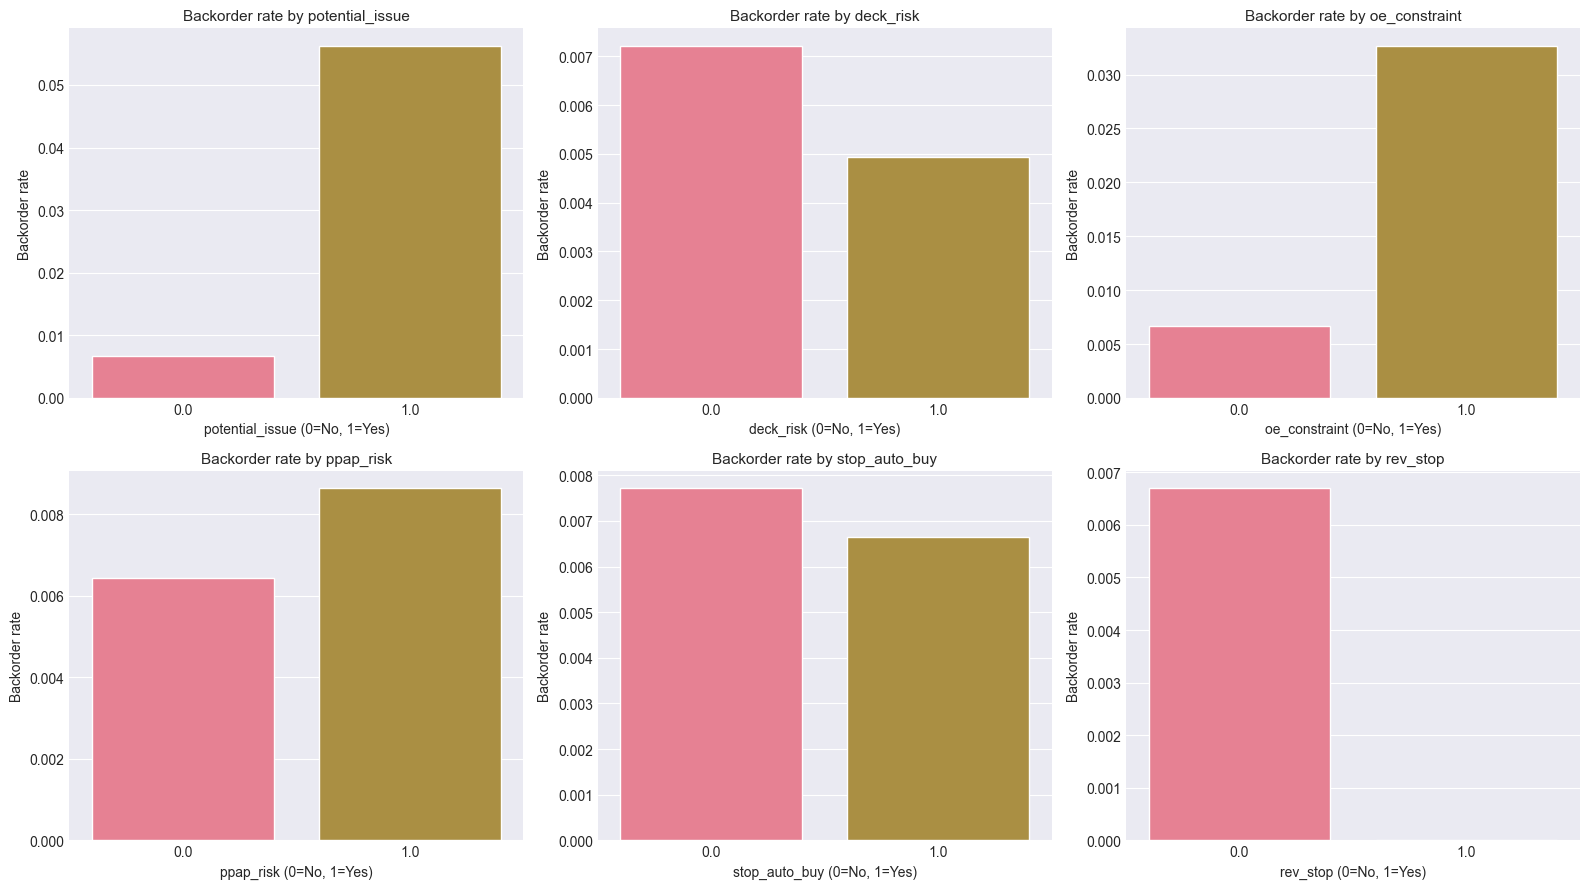

In [14]:
# compute backorder rate for each flag value
rate_rows = []
for col in risk_flag_cols:
    tmp = (
        df_eda.groupby(col)["went_on_backorder"]
        .mean()
        .reset_index()
        .rename(columns={"went_on_backorder": "backorder_rate"})
    )
    tmp["feature"] = col
    rate_rows.append(tmp)

rates = pd.concat(rate_rows, ignore_index=True)

# Grid layout
n_cols = 3
n_rows = math.ceil(len(risk_flag_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4.5 * n_rows))
axes = axes.flatten()

for i, col in enumerate(risk_flag_cols):
    ax = axes[i]
    plot_df = rates[rates["feature"] == col].copy()

    sns.barplot(
        data=plot_df,
        x=col,
        y="backorder_rate",
        ax=ax
    )
    ax.set_title(f"Backorder rate by {col}", fontsize=11)
    ax.set_xlabel(f"{col} (0=No, 1=Yes)")
    ax.set_ylabel("Backorder rate")

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


<div class="alert alert-block alert-warning">

**Interpretation:**
- **potential_issue** - potential issue exhibit a dramatically higher backorder rate than those without. This suggests the flag captures meaningful, forward-looking operational concerns and is a strong predictor of backorder risk.
- **deck_risk** - Unexpectedly, SKUs without deck risk show a slightly higher backorder rate than those with deck risk. This indicates that deck risk may not directly correspond to immediate supply failure
- **oe_constraint** - The presence of an original equipment constraint is associated with a substantially higher backorder rate. This aligns with the intuition that restricted sourcing options significantly increase vulnerability to supply disruptions.
- **ppap_risk** - SKUs with PPAP risk have a higher backorder rate than those without, though the difference is more moderate. This suggests compliance or approval delays contribute to risk, but may act more as a secondary or interacting factor.
- **rev_stop** - Revenue stop flags are extremely rare, and no backorders are observed when this flag is active.
- **stop_auto_buy** - SKUs where automatic purchasing is stopped show a slightly lower backorder rate. This likely reflects proactive human intervention where planners may disable automation precisely to prevent stockouts for already-risky items.

In [15]:
summary = []
for col in numeric_cols:
    grp = df_eda.groupby("went_on_backorder")[col]
    row = {
        "feature": col,
        "median_non": grp.median().get(0, np.nan), # Median value for non-backordered SKUs,
        "median_yes": grp.median().get(1, np.nan), # Median value for backordered SKUs,
        "mean_non": grp.mean().get(0, np.nan), # Mean value for non-backordered SKUs,
        "mean_yes": grp.mean().get(1, np.nan), # Mean value for backordered SKUs,
    }
    row["median_diff_yes_minus_no"] = row["median_yes"] - row["median_non"]
    summary.append(row)

num_sep = (
    pd.DataFrame(summary)
    .sort_values("median_diff_yes_minus_no", ascending=False)
    # measure of how typical (median) value of a feature changes when a SKU goes on backorder
)

num_sep.head(20)


,feature,median_non,median_yes,mean_non,mean_yes,median_diff_yes_minus_no
5,forecast_9_month,0.000,24.000,507.580,325.940,24.000
4,forecast_6_month,0.000,19.000,345.662,244.679,19.000
9,sales_9_month,4.000,19.000,527.418,206.378,15.000
3,forecast_3_month,0.000,12.000,178.259,157.314,12.000
8,sales_6_month,2.000,14.000,343.093,139.271,12.000
7,sales_3_month,1.000,8.000,175.670,79.351,7.000
6,sales_1_month,0.000,3.000,56.105,29.364,3.000
1,lead_time,8.000,8.000,7.890,6.371,0.000
2,in_transit_qty,0.000,0.000,44.320,4.339,0.000
10,min_bank,0.000,0.000,52.965,24.220,0.000


<div class="alert alert-block alert-warning">

This table highlights which numeric variables differ most between the two outcome classes.
Features near the top are likely to be informative predictors, while those near zero show
little standalone separation. The table complements visual bivariate plots and helps guide
feature selection and modelling priorities.

**Interpretation**:
* backorder sku's have higher recent sales and higher forecasted demand than those that do not, meaning demand is present (and predicted), but fulfillment fails.
* inventory stress indicators and supplier risk flags provide secondary but complementary signals.
* **The results justify a modelling approach
that handles skewed numeric variables, leverages non-linear interactions, and retains
binary operational flags despite their low standalone medians.**


<div class="alert alert-block alert-info">

To wrap up the EDA and extract the last signals that would help with modelling, I will look for :
* multicollinearity and correlations to know which variables would gve redundant information.
* class imbalance in target variable so I know what metics should be prioritised in the evalutaion
* skew and heavy zeros: since I found earlier that demand-related variables are zero-inflated and heavy-tailed, which often favours tree-based models and/or log-style transforms.

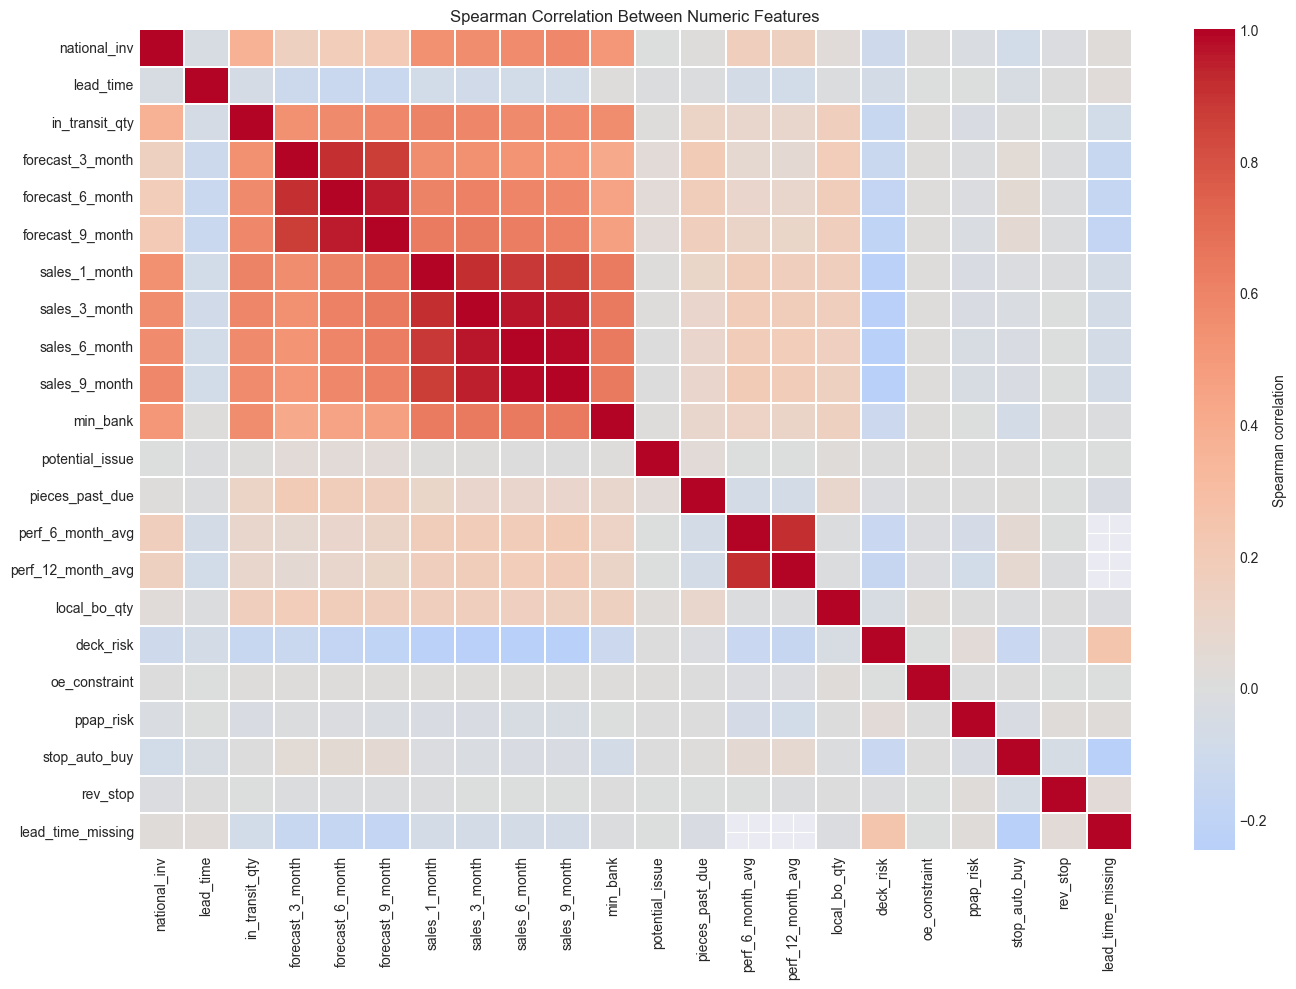

In [16]:
# Checking correlations since many numeric variables represent the same underlying concept measured over different horizons

num_cols = (
    df_eda
    .select_dtypes(include=[np.number])
    .drop(columns=["went_on_backorder"], errors="ignore")
)

# spearman correlation
corr = num_cols.corr(method="spearman")

# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(
    corr,
    cmap="coolwarm",
    center=0,
    cbar_kws={"label": "Spearman correlation"},
    linewidths=0.3
)
plt.title("Spearman Correlation Between Numeric Features")
plt.tight_layout()
plt.show()

<div class="alert alert-block alert-warning">

**Interpretation:**
* Most correlations make business sense and align with how supply chains behave.
* Sales and forecast variables basically measure demand over different horizons. Longer horizons correlate more strongly with each other than with short horizons. This is expected and a good sign.
    * Tree-based models will handle this redundancy naturally. Linear models may require regularisation (L1/L2) or feature selection.
* national_inv, in_transit_qty, min_bank show moderate positive correlations with sales/forecast. This reflects normal inventory planning behavior where more demand → more inventory positioning.
    * These variables are complementary to each other
* lead_time has weak correlations with all features. This could mean that lead time is driven by supplier/process factors, not demand alone.
    * Makes it a strong candidate for early-warning prediction.
* perf_6_month_avg and perf_12_month_avg are very strongly correlated with each other, and weakly correlated with the demand and inventory features. Their separation from demand shows that they add independent explanatory power.
* Risk flags (deck_risk, ppap_risk, oe_constraint, etc.) show very low correlation with other features and with each other
    * These are event-based/ process-based information that inject non-continuous risk information.

In [17]:
# class imbalance confirmation
backorder_rate = df_eda["went_on_backorder"].mean()

print(f"Backorder rate: {backorder_rate:.4%}")
print(df_eda["went_on_backorder"].value_counts(normalize=True))


Backorder rate: 0.6691%
went_on_backorder
0.000   0.993
1.000   0.007
Name: proportion, dtype: float64


<div class="alert alert-block alert-warning">

* This is a severely imbalanced classification problem.
* Backorders are rare but operationally critical events.

**Implications:**
* **Accuracy is meaningless as a metric.**
* ROC AUC alone is insufficient, I would need **Precision–Recall curves.**
* **Class weighting or threshold tuning** will be required.
* This further **justifies tree-based models** first, as they:
    * Handle imbalance better out-of-the-box
    * Are more robust to skewed decision boundaries

In [18]:
# log transformations
skewed_cols = [
    "national_inv",
    "forecast_3_month", "forecast_6_month", "forecast_9_month",
    "sales_1_month", "sales_3_month", "sales_6_month", "sales_9_month",
    "min_bank"
]

for col in skewed_cols:
    df_eda[f"{col}_log"] = np.log1p(df_eda[col])


<div class="alert alert-block alert-info">

## 3. Feature Engineering

Now that all the data has been preprocessed and explored, I will move on to feature engineering. My aim is to use the features available to create a set of signals that can be easily interpreted by a planner, controls for leakage (based on “planning-time” information), is helpful across all the models that I want to test, and generalise better than the raw features. My idea is to create 3 different sets that include inventory-coverage, deviation of expected vs actual demand and forecast, and supply stress indicators (like the ones that I found to be separate to operational supply chain features). This is better explained as follows:
1. **Inventory coverage ratio** - Inventory available relative to forecasted demand (coverage) is often a strong backorder signal. Thus, by calculating this I (or a planner) can understand how many forecasted units can be covered with the current inventory.
    * calculated by national_inv/ forecast_X_month
2. **Demand trend & forecast deviation** - Historical sales & forecast - realized sales -> can capture the mismatch of the demand shifts and forecasting made by a planner
3. **Supply stress indicators** - Binary flags for overdue / backorder / in-transit can capture sharp risk jumps (especially useful for linear models with many zeros).

In [19]:
def add_feature_engineering(df: pd.DataFrame) -> pd.DataFrame:
    '''
     This function is deterministic and can be applied to train/val/test consistently.
    '''
    out = df.copy()

    # 1) coverage ratios -  inventory relative to forecast
    safe = 1.0  # small safety constant to avoid division by zero
    for horizon in ["3", "6", "9"]:
        f = f"forecast_{horizon}_month"
        if f in out.columns:
            out[f"coverage_{horizon}m"] = out["national_inv"] / (out[f] + safe)

    # A more supply-chain-like "net inventory position" proxy would also capture the inventory in transit, so I can include that too
    # inventory + in_transit - (short-term forecast)
    if "forecast_3_month" in out.columns:
        out["net_inv_pos_3m"] = out["national_inv"] + out.get("in_transit_qty", 0) - out["forecast_3_month"]


    # 2) demand trend & forecast deviation
    if "sales_1_month" in out.columns and "sales_6_month" in out.columns:
        out["recent_vs_past_sales"] = (out["sales_1_month"] + safe) / (out["sales_6_month"] + safe) # last month compared to medium-term sales

    # Forecast bias: forecast - realized sales
    pairs = [("forecast_3_month", "sales_3_month"),
             ("forecast_6_month", "sales_6_month"),
             ("forecast_9_month", "sales_9_month")]
    for fc, sl in pairs:
        if fc in out.columns and sl in out.columns:
            out[f"forecast_bias_{fc.split('_')[1]}"] = out[fc] - out[sl]
            # Positive = forecast higher than sales (potential over-forecast),
            # Negative = forecast lower than sales (potential under-forecast)

    # 3) heavy-zero indicators
    sparse_count_cols = [
        "in_transit_qty",
        "pieces_past_due",
        "local_bo_qty",
        "sales_1_month",
        "sales_3_month",
        "sales_6_month",
        "sales_9_month"
    ]
    for c in sparse_count_cols:
        if c in out.columns:
            # since values are either 0 or positive, I am making a non-zero flag that lets the model learn a separate effect for presence vs absence of inventory/shipments/backorders
            out[f"{c}_nonzero"] = (out[c].fillna(0) > 0).astype(int)

    return out


In [20]:
# apply feature eng to train and test safely now
df_fe = add_feature_engineering(df_eda)
print("Original columns:", df_eda.shape[1])
print("After feature engineering:", df_fe.shape[1])
# show the newest engineered features
new_cols = [c for c in df_fe.columns if c not in df_eda.columns]
df_fe

Original columns: 33
After feature engineering: 48


,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder,lead_time_missing,national_inv_log,forecast_3_month_log,forecast_6_month_log,forecast_9_month_log,sales_1_month_log,sales_3_month_log,sales_6_month_log,sales_9_month_log,min_bank_log,coverage_3m,coverage_6m,coverage_9m,net_inv_pos_3m,recent_vs_past_sales,forecast_bias_3,forecast_bias_6,forecast_bias_9,in_transit_qty_nonzero,pieces_past_due_nonzero,local_bo_qty_nonzero,sales_1_month_nonzero,sales_3_month_nonzero,sales_6_month_nonzero,sales_9_month_nonzero
0,1026827,0.000,8.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,NaN,NaN,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0,0,0,0,0,0,0
1,1043384,2.000,9.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.990,0.990,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0,1.099,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2.000,2.000,2.000,2.000,1.000,0.000,0.000,0.000,0,0,0,0,0,0,0
2,1043696,2.000,8.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,NaN,NaN,0.000,1.000,0.000,0.000,1.000,0.000,0.000,1,1.099,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2.000,2.000,2.000,2.000,1.000,0.000,0.000,0.000,0,0,0,0,0,0,0
3,1043852,7.000,8.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.100,0.130,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0,2.079,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.693,7.000,7.000,7.000,7.000,1.000,0.000,0.000,0.000,0,0,0,0,0,0,0
4,1044048,8.000,8.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,4.000,2.000,0.000,0.000,NaN,NaN,0.000,1.000,0.000,0.000,1.000,0.000,0.000,1,2.197,0.000,0.000,0.000,0.000,0.000,0.000,1.609,1.099,8.000,8.000,8.000,8.000,1.000,0.000,0.000,-4.000,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1687856,1373987,-1.000,8.000,0.000,5.000,7.000,9.000,1.000,3.000,3.000,8.000,0.000,0.000,0.000,NaN,NaN,1.000,0.000,0.000,0.000,1.000,0.000,0.000,1,-inf,1.792,2.079,2.303,0.693,1.386,1.386,2.197,0.000,-0.167,-0.125,-0.100,-6.000,0.500,2.000,4.000,1.000,0,0,1,1,1,1,1
1687857,1524346,-1.000,9.000,0.000,7.000,9.000,11.000,0.000,8.000,11.000,12.000,0.000,0.000,0.000,0.860,0.840,1.000,1.000,0.000,0.000,0.000,0.000,1.000,0,-inf,2.079,2.303,2.485,0.000,2.197,2.485,2.565,0.000,-0.125,-0.100,-0.083,-8.000,0.083,-1.000,-2.000,-1.000,0,0,1,0,1,1,1
1687858,1439563,62.000,9.000,16.000,39.000,87.000,126.000,35.000,63.000,153.000,205.000,12.000,0.000,0.000,0.860,0.840,6.000,0.000,0.000,0.000,1.000,0.000,0.000,0,4.143,3.689,4.477,4.844,3.584,4.159,5.037,5.328,2.565,1.550,0.705,0.488,39.000,0.234,-24.000,-66.000,-79.000,1,0,1,1,1,1,1
1687859,1502009,19.000,4.000,0.000,0.000,0.000,0.000,2.000,7.000,12.000,20.000,1.000,0.000,0.000,0.730,0.780,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0,2.996,0.000,0.000,0.000,1.099,2.079,2.565,3.045,0.693,19.000,19.000,19.000,19.000,0.231,-7.000,-12.000,-20.000,0,0,1,1,1,1,1


<div class="alert alert-block alert-warning">

**How to interpret this table:**

* **coverage_3m, coverage_6m, coverage_9m** -
    * Shows how many months of demand can the current inventory cover; unit is months
        * lower coverage tends to be associated with higher backorder risk, because there is less buffer versus demand/supply
* **net_inv_pos_3m (net inventory position)** -
    * Shows a net buffer as net inventory position ≈ on-hand inventory + in-transit − expected demand; unit is the product count
        * negative means the demand pressure exceeds available supply buffer, which is riskier. Thus, more negative net position should correlate with higher backorder probability
* **recent_vs_past_sales… (a ratio / growth indicator)** -
    * Shows whether demand is accelerating (>1) or decelerating (<1)
        * increasing demand can increase backorder risk if planner do not push supply in time.
* **forecast_bias_3, forecast_bias_6, forecast_bias_9** -
    * Shows if the forecast is over (+) or under-predicting (-) demand
        * under-forecasting can create shortages if replenishment decisions rely only on forecast
* **sales_1_month_nonzero, in_transit_qty_nonzero, pieces_past_due_nonzero, local_bo_qty_nonzero** -
    * Shows presence or absence (1/0) of the features and can explain if & when something happens on the supplier side, and what the effect of it is

**Great, feature engineerng is now completed. These features have been designed to reduce redundancy across time windows, expose non-linear relationships, and make key business concepts like coverage and shortage, explicit for the model. I have also created them in a way that supply chain planner would be able to infer a lot about the state of the operations from these engineered features alone (with the help of the guide I created above). Now I will move on to modelling:**

<div class="alert alert-block alert-info">

## 4) Modelling
The dataset is large and the positive class (actual backorders) is rare. That means:
- A naïve classifier that **always predicts “no backorder”** can achieve very high **accuracy** while being completely useless in practice.
- Metrics that treat both classes symmetrically (like plain accuracy) are therefore misleading for model selection and tuning.

From an operations perspective, the costs are **asymmetric**:
- **Missing a true backorder (false negative)** is more painful because if a risky SKU slips through, planners are not warned, and the organisation loses revenue
- **Raising a false alarm (false positive)** is annoying and may lead to some wasted effort, but is often cheaper than missing a serious shortage, especially for high-value or critical parts.

Keeping all this in mind, I will implement 3 models:
1. **Logistic Regression (with class weights)**
    * Use class_weight="balanced"
    * Possibly log-transform some skewed features (only here though, the remaining two are robust)
        * Evaluate with recall + PR-AUC, not accuracy
2. **Random Forest (baseline non-linear model)**
    * Shallow-moderate depth trees
    * Class weights or balanced subsampling
3. **Gradient Boosting (XGBoost)**
    * Early stopping
    * Scale-positive-weight for imbalance

(Considered neural networks but this might be an overkill and have low interpretability)

As a result, we care particularly about: **can put this in evaluation section also**

- **Recall** (or sensitivity) for the positive class – what fraction of actual backorders we successfully flag.
- **Precision** for the positive class – among the SKUs we flag, how many really do go on backorder.
- **ROC AUC** and **Precision–Recall curves** – to understand the trade-off between catching more backorders and triggering more false alarms across different probability thresholds.

### 4.1 Logistic Regression
Logistic Regression is used as a transparent baseline to validate feature engineering
and understand the directional impact of engineered features on backorder risk.

Given the strong class imbalance and asymmetric cost of errors, the model is trained
with class weighting and evaluated using recall and precision–recall AUC rather than accuracy.


In [38]:
df_model = df_fe.copy()
target = "went_on_backorder"
# BEFORE anything, i need to see the unique values
print("Target unique values (incl NaN):")
print(df_model[target].value_counts(dropna=False)) # has nan values still so i need to drop them

Target unique values (incl NaN):
went_on_backorder
0.000    1676567
1.000      11293
NaN            1
Name: count, dtype: int64


In [40]:
# cleaning the target and mapping again
if df_model[target].dtype == "O":  # object/string
    df_model[target] = (
        df_model[target]
        .astype(str)
        .str.strip()
        .str.lower()
        .replace({"yes": 1, "no": 0})
    )
# convert to numeric (coerce anything weird to NaN)
df_model[target] = pd.to_numeric(df_model[target], errors="coerce")
# check how many NaNs remain
n_nan = df_model[target].isna().sum()
print("\nNaNs in target after cleaning:", n_nan)
# drop rows with missing target (cannot train otherwise)
df_model = df_model.dropna(subset=[target]).copy()
print("Final target distribution:")
print(df_model[target].value_counts(normalize=True))

# Build X and y
X = df_model.drop(columns=[target])
y = df_model[target].astype(int)

print("\nShapes -> X:", X.shape, " y:", y.shape)


NaNs in target after cleaning: 1
Final target distribution:
went_on_backorder
0.000   0.993
1.000   0.007
Name: proportion, dtype: float64

Shapes -> X: (1687860, 47)  y: (1687860,)


nan was breaking my initial modelling so it was necessary for me to take it out

In [41]:

X = X.replace([np.inf, -np.inf], np.nan) # imputing using mean because:
'''
During feature engineering, a small number of ratio-based variables produced infinite values due to edge cases in forecast denominators. These have been safely converted to missing values and handled via median imputation, ensuring numerical stability without distorting model signal.
'''
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

log_reg = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=2000, class_weight="balanced"))
])

log_reg.fit(X_train, y_train)

val_proba = log_reg.predict_proba(X_val)[:, 1]
val_pred = (val_proba >= 0.5).astype(int)

print("ROC-AUC:", round(roc_auc_score(y_val, val_proba), 4))
print("PR-AUC :", round(average_precision_score(y_val, val_proba), 4))
print("\nConfusion matrix:\n", confusion_matrix(y_val, val_pred))
print("\nReport:\n", classification_report(y_val, val_pred, digits=3))


ROC-AUC: 0.9431
PR-AUC : 0.1465

Confusion matrix:
 [[290681  44632]
 [   241   2018]]

Report:
               precision    recall  f1-score   support

           0      0.999     0.867     0.928    335313
           1      0.043     0.893     0.083      2259

    accuracy                          0.867    337572
   macro avg      0.521     0.880     0.505    337572
weighted avg      0.993     0.867     0.923    337572



<div class="alert alert-block alert-warning">

So I used logistic regression as a baseline classification model to predict whether a product will go on backorder.
The model was trained on my final feature-engineered dataset (df_fe), ensuring all preprocessing and domain-driven features were already included. To explain what the code above did:
* for missing values → I used median imputation
* for feature scale differences → I applied standardization
* for severe class imbalance (very few backorders as seen in my output above) → I used class_weight="balanced"
* and any numerical edge cases where I got infinite values from ratio features (in df_fe) were safely converted to missing values and handled through imputation

**Outputs**:
* **ROC-AUC = 0.943** indicates strong overall ranking ability: the model is good at separating high-risk vs low-risk items.
* **PR-AUC = 0.147** reflects the extreme class imbalance and shows that, while recall is high, precision remains limited for true backorder identification.

**Confusion matrix interpretation:**
* 241 true backorders correctly identified
* 2018 false alarms (backorder was predicted but did not occur)

**Classification report for both classes interpretation:**
* class 0: given the dominance of this class, the metric values are expected
    * Precision: 0.999: when the model predicts 'no backorder', it is almost ALWAYS correct
    * Recall: 0.867: most normal cases are correctly identified
    * F1-score: 0.928: very strong performance
* class 1:
    * Precision: 0.043: only ~4% of predicted backorders are real, this is a very low score
    * Recall: 0.893: model catches ~89% of actual backorders
    * F1-score: 0.083: shows the precision–recall trade-off under heavy imbalance

**What i understood from this model:**
* model is good at detecting backorders (due to high recall)
* but bad at filtering false alarms (low precision)
* gave a clear recall benchmark (~89%)
* shows that what needs improvement is reducing false positives and capturing non-linear interactions

I will now move to Random Forest, which handles non-linear relationships, is robust to outliers and typically improves precision without destroying recall.

<div class="alert alert-block alert-info">

### 4.2 Random Forest

In [42]:
# Safety (same as before)
X = X.replace([np.inf, -np.inf], np.nan)
# Same split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# rf pipeline of impute -> model (median imputation as trees can’t handle NaNs directly)
rf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("model", RandomForestClassifier(
        n_estimators=300,            # strong but still reasonable runtime
        random_state=42,
        n_jobs=-1,
        class_weight="balanced_subsample",
        max_depth=None,              # let it learn non-linearities
        min_samples_leaf=2           # small regularization to reduce overfitting
    ))
])

rf.fit(X_train, y_train)
val_proba = rf.predict_proba(X_val)[:, 1]
val_pred  = (val_proba >= 0.5).astype(int)
print("ROC-AUC:", round(roc_auc_score(y_val, val_proba), 4))
print("PR-AUC :", round(average_precision_score(y_val, val_proba), 4))
print("\nConfusion matrix:\n", confusion_matrix(y_val, val_pred))
print("\nReport:\n", classification_report(y_val, val_pred, digits=3))


ROC-AUC: 0.9762
PR-AUC : 0.4464

Confusion matrix:
 [[334948    365]
 [  1587    672]]

Report:
               precision    recall  f1-score   support

           0      0.995     0.999     0.997    335313
           1      0.648     0.297     0.408      2259

    accuracy                          0.994    337572
   macro avg      0.822     0.648     0.702    337572
weighted avg      0.993     0.994     0.993    337572



<div class="alert alert-block alert-warning">

**Output interpretation:**
* **ROC-AUC = 0.976**: shows an improvement over logistic regression, indicating better discrimination between the classes.
* **PR-AUC = 0.446**: shows a substantial gain, showing the model is far more effective at identifying true backorders under heavy imbalance.
* This confirms that non-linear patterns and feature interactions matter in backorder risk.

**Confusion matrix interpretation:**
* **True Negatives (334948)**: the model correctly identifies almost all non-backorder cases, improving further on the already strong performance of logistic regression.
* **False Positives (365)**: compared to logistic regression’s high number of false alarms, RFdramatically reduces unnecessary backorder flags and making predictions better.
* **False Negatives (1587)**: the model misses more backorders than logistic regression
* **True Positives (672)**: while fewer than in logistic regression, these detected backorders are identified with much higher certainty.

**Classification report for both classes interpretation:**
* class 0: once again this class performs very well.
    * Precision: 0.995
    * Recall: 0.999
    * F1-score: 0.997
* class 1:
    * Precision: 0.648: a major improvement over logistic regression, meaning most predicted backorders are now genuine.
    * Recall: 0.297: lower than logistic regression, indicating fewer total backorders are captured.
    * F1-score: 0.408: reflects a much better balance between precision and recall than in logistic regression.

**What i understood from this model:**
* Compared to logistic regression, the model sacrifices some recall in exchange for dramatically fewer false positives, making it better suited for operational intervention.
* RF significantly improves precision and PR-AUC
* this perfromance suggests that backorder risk is driven by complex, non-linear interactions that simpler linear models cannot fully capture

In [43]:
# Quick feature importance (top 15)
rf_model = rf.named_steps["model"]
importances = pd.Series(rf_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print("\nTop 15 feature importances:")
print(importances.head(15))


Top 15 feature importances:
coverage_6m            0.106
net_inv_pos_3m         0.097
coverage_3m            0.090
coverage_9m            0.084
sku                    0.057
national_inv           0.038
forecast_3_month       0.034
forecast_9_month_log   0.032
national_inv_log       0.031
forecast_3_month_log   0.031
forecast_6_month       0.030
forecast_9_month       0.028
perf_12_month_avg      0.026
forecast_6_month_log   0.026
perf_6_month_avg       0.026
dtype: float64


<div class="alert alert-block alert-warning">

The above reveals interesting things abut supply chain:
* Coverage ratios (3m, 6m, 9m) are very important and show that *backorder risk is primarily driven by inventory relative to expected demand, rather than absolute stock levels alone.*
* net inventory position (3m) suggests the model is sensitive to forward-looking shortages, capturing risk before inventory is fully depleted.
* National inventory and forecast variables (raw and log) have similar importance, implying that both scale effects (large vs small volumes) and relative differences matter for risk assessment.
* The presence of SKU among the top features indicates product-specific risk patterns, likely reflecting structural differences in sourcing, lead times, etc.

Next, I will move on to XGBoost that builds trees sequentially and focuses on correcting the mistakes of the previous ones.

<div class="alert alert-block alert-info">

### 4.3 Gradient Boosting - XGBoost

As learned in class,
* Logistic Regression
→ linear, high recall, lots of false positives

* Random Forest
→ non-linear, high precision, fewer alerts

* XGBoost
→ aims to recover recall while keeping precision high

In [44]:
# Safety again
X_xgb = X.replace([np.inf, -np.inf], np.nan)

# Compute imbalance ratio for scale_pos_weight
neg, pos = np.bincount(y_train) # counts number of class 0, 1 (negative and positive)
scale_pos_weight = neg / pos
print("scale_pos_weight:", round(scale_pos_weight, 2))

scale_pos_weight: 148.47


Meaning that backorders are ~150× rarer than non-backorders.

In [47]:
# Define XGBoost model
xgb = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="aucpr", # focus on PR-AUC
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1
)

# fix: drop SKU because it is object and not numeric - was giving me issues earlier so had to drop
X_train_xgb = X_train.drop(columns=["sku"], errors="ignore")
X_val_xgb   = X_val.drop(columns=["sku"], errors="ignore")

# fit with early stopping
xgb.fit(
    X_train_xgb, y_train,
    eval_set=[(X_val_xgb, y_val)],
    early_stopping_rounds=50,
    verbose=False
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [49]:
# Evaluate
val_proba_xgb = xgb.predict_proba(X_val_xgb)[:, 1]
val_pred_xgb  = (val_proba_xgb >= 0.5).astype(int)
print("XGBoost ROC-AUC:", round(roc_auc_score(y_val, val_proba_xgb), 4))
print("XGBoost PR-AUC :", round(average_precision_score(y_val, val_proba_xgb), 4))
print("\nConfusion matrix:\n", confusion_matrix(y_val, val_pred_xgb))
print("\nReport:\n", classification_report(y_val, val_pred_xgb, digits=3))


XGBoost ROC-AUC: 0.9661
XGBoost PR-AUC : 0.2738

Confusion matrix:
 [[308257  27056]
 [   246   2013]]

Report:
               precision    recall  f1-score   support

           0      0.999     0.919     0.958    335313
           1      0.069     0.891     0.129      2259

    accuracy                          0.919    337572
   macro avg      0.534     0.905     0.543    337572
weighted avg      0.993     0.919     0.952    337572



<div class="alert alert-block alert-warning">

**Output interpretation:**
* **ROC-AUC = 0.9661**: very slightly less than RF but remains very strong
* **PR-AUC = 0.2738**: improves substantially over logistic regression but much less than RF, reflecting a trade-off between recall and precision.
* This shows XGBoost prioritises recovering missed backorders rather than aggressively filtering false positives.

**Confusion matrix interpretation:**
* **True Negatives (308257)**: fewer than RF, indicating the model is more willing to flag potential risk cases.
* **False Positives (27056)**: significantly higher than RF meaning XGBoost casts a wider net, closer to logistic regression behaviour.
* **False Negatives (246)**: dramatically reduced compared to Random Forest, meaning far fewer true backorders are missed.
* **True Positives (2013)**: much more than RF detected, nearly matches logistic regression, confirming XGBoost’s strength in detecting rare backorder events.

**Classification report for both classes interpretation:**
* class 0: this class continues to perform well
    * Precision: 0.999
    * Recall: 0.919:  lightly lower than RF reflecting increased false positives.
    * F1-score: 0.958
* class 1:
    * Precision: 0.069: much lower than RF indicating many flagged backorders are false alarms.
    * Recall: 0.891: very high, comparable to logistic regression, meaning most backorders are successfully detected.
    * F1-score: 0.129

**What i understood from this model:**
* XGBoost behaves as a high-recall risk detector, successfully identifying most backorders but at the cost of many false positives. However, since false positives are less costly than false negatives, this chance is worth taking.
* Compared to Random Forest, it sacrifices precision to substantially reduce missed backorders.
* Compared to logistic regression, it improves overall ranking ability and PR-AUC while maintaining similar recall.
* **This positions XGBoost as a screening or early-warning model, whereas Random Forest is better suited for high-confidence operational decisions.**

<div class="alert alert-block alert-info">

### ROC Curve to compare the models performance

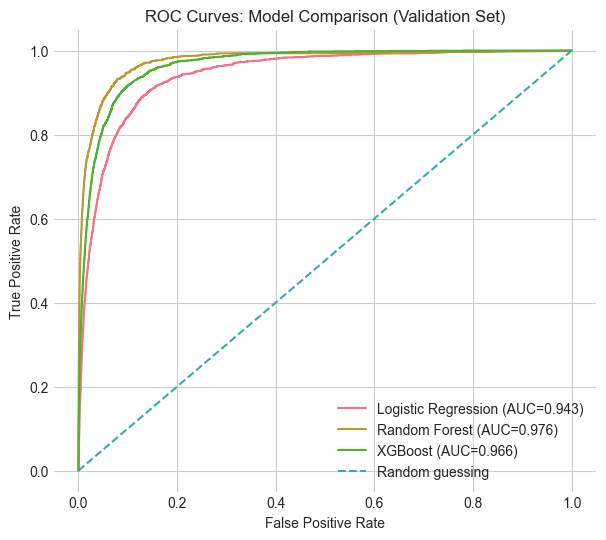

In [51]:
from sklearn.metrics import roc_curve, auc

# getting predicted probabilities on the same validation set
proba_lr = log_reg.predict_proba(X_val)[:, 1]
proba_rf = rf.predict_proba(X_val)[:, 1] # both can use X_val directly

# XGBoost drop sku if it exists still
X_val_xgb = X_val.drop(columns=["sku"], errors="ignore")
proba_xgb = xgb.predict_proba(X_val_xgb)[:, 1]

# roc
fpr_lr, tpr_lr, _ = roc_curve(y_val, proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_val, proba_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_val, proba_xgb)
auc_lr = auc(fpr_lr, tpr_lr)
auc_rf = auc(fpr_rf, tpr_rf)
auc_xgb = auc(fpr_xgb, tpr_xgb)

# plot
plt.figure(figsize=(7, 6))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC={auc_lr:.3f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC={auc_rf:.3f})")
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC={auc_xgb:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random guessing")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves: Model Comparison (Validation Set)")
plt.legend()
plt.grid(True)
plt.show()


<div class="alert alert-block alert-warning">

**Interpretation of the ROC curve:**
* All three models perform far above random guessing
* Random Forest has the highest ROC-AUC
* XGBoost is very close
* Logistic Regression is clearly the weakest of the three
* **But the ROC curves do NOT capture cost asymmetry or class imbalance well.**
    * thats why RF looks best on ROC but XGBoost looks better on recall and early detection

Going to my original goal, which was to build a very good early-warning system, given the constraint that false negatives are more costly than false positives, RF and XGboost can be compared:

**Random Forest (high-confidence model)**
* Precision (class 1): 0.648
* Recall (class 1): 0.297
* Very few false positives
* **Misses ~70% of true backorders so not ideal if missing a backorder is very costly.**

**XGBoost (early-warning model)**
* Precision (class 1): 0.069
* Recall (class 1): 0.891
* Catches almost all backorders
* **Many false positives so it flags anything that might go wrong, even if there are some false alarms**

**Therefore, I select XGBoost as the final model because it better aligns with the project’s objective of early risk detection, prioritising recall in a context where missed backorders are more costly than false alerts**

<div class="alert alert-block alert-info">

### 5. Local explanability - SHAP
I will find the SHAP values on a random subset of the training data (5000 observations) that are fit the final XGBoost model. These samples are representative of the data distribution the model learned from and are used to explain model behaviour, not generalisation performance. Test data is reserved strictly for final evaluation.

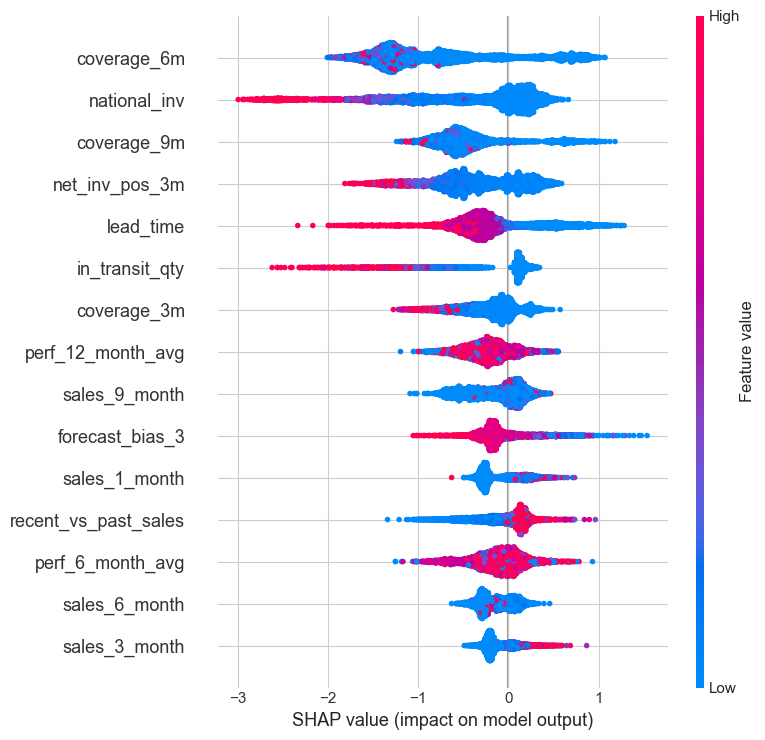

In [60]:
# using a sample
X_shap = X_all  _xgb.sample(n=min(5000, len(X_all_xgb)), random_state=42)
explainer = shap.TreeExplainer(final_xgb)
shap_values = explainer.shap_values(X_shap)

# summary plot (global impact + direction)
plt.figure(figsize=(8, 5))
shap.summary_plot(
    shap_values,
    X_shap,
    show=False,
    max_display=15 # top 15 features only
)
plt.tight_layout()
plt.show()



<div class="alert alert-block alert-warning">

**Beeswarm plot interpretation:**
This plot summarises how each feature contributes to the model’s prediction across many training samples. Each point is one observation, its horizontal position shows whether that feature pushes the prediction towards or away from backorder risk, and the colour encodes whether the feature value is low (blue) or high (red).
* The model is driven primarily by coverage ratios and inventory position variables, with coverage_6m emerging as the strongest global driver. Low coverage values (blue points) consistently push predictions toward higher backorder risk, while higher coverage values push risk down. This aligns directly with supply-chain intuition that insufficient inventory relative to medium-term demand is a strong early warning signal.
* Variables such as national_inv, net_inv_pos_3m, and lead_time further reinforce this story, indicating that absolute inventory levels, short-term inventory pressure, and replenishment delays jointly shape backorder risk.


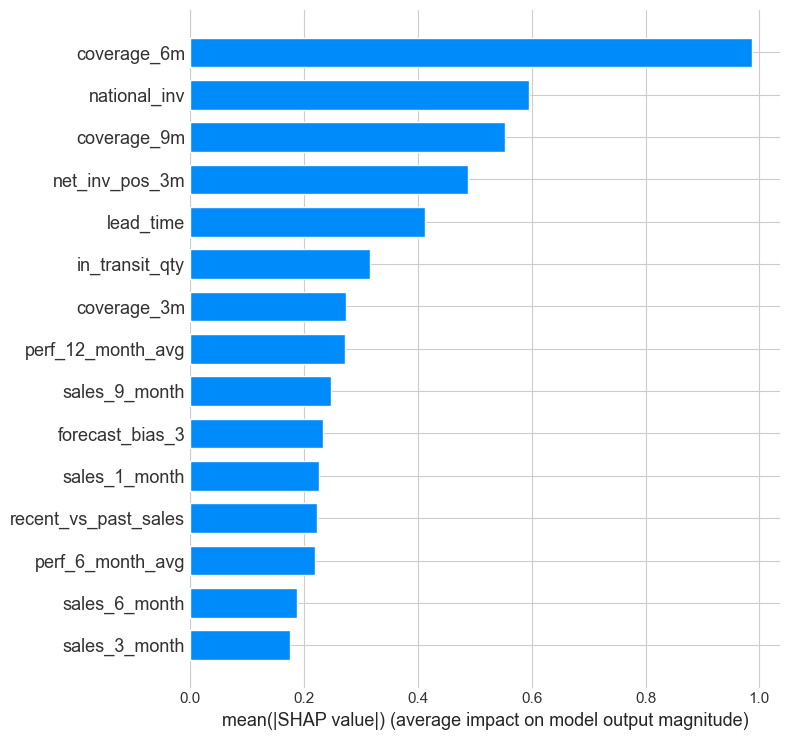

In [62]:
# bar plot (top features)
plt.figure(figsize=(7, 4))
shap.summary_plot(
    shap_values,
    X_shap,
    plot_type="bar",
    show=False,
    max_display=15
)
plt.tight_layout()
plt.show()



<div class="alert alert-block alert-warning">

**Bar plot interpretation:**
* This plot aggregates SHAP values across all explained samples and ranks features by their average absolute contribution to model predictions.
* The dominance of coverage_6m, coverage_9m, and net_inv_pos_3m confirms that the model prioritises forward-looking supply–demand balance rather than short-term fluctuations alone.
* Inventory-related features consistently outrank sales metrics, suggesting that backorders are driven more by structural stock than by recent demand spikes.
* Forecast bias and recent sales ratios appear lower in importance but still meaningful indicating that demand acts as a secondary risk signal rather than the primary signal.

Top SHAP feature: coverage_6m


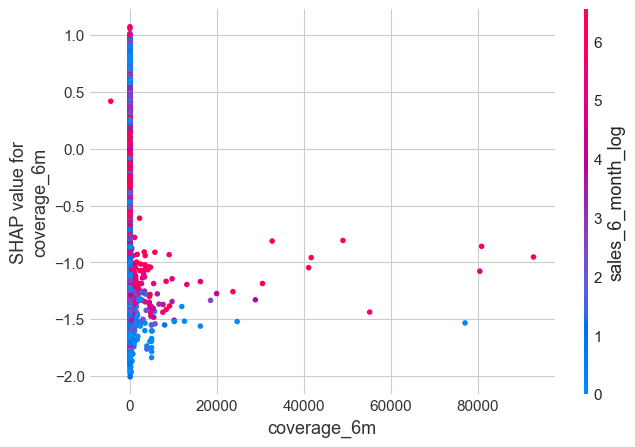

In [63]:
# dependence plot for my top feature coverage
top_feature = X_shap.columns[np.abs(shap_values).mean(axis=0).argmax()]
print("Top SHAP feature:", top_feature)
shap.dependence_plot(top_feature, shap_values, X_shap)

<div class="alert alert-block alert-warning">

**Dependence plot intepretation:**
* This plot zooms into a single feature (coverage_6m) and shows how its value affects predictions, while colouring points by a second interacting feature (sales intensity).
* plot reveals a clear threshold-like behaviour that very low coverage values strongly increase predicted backorder risk, after which marginal increases in coverage sharply reduce risk.
* Beyond a certain point, additional coverage yields diminishing returns, suggesting a non-linear saturation effect.

Chosen value: 237180


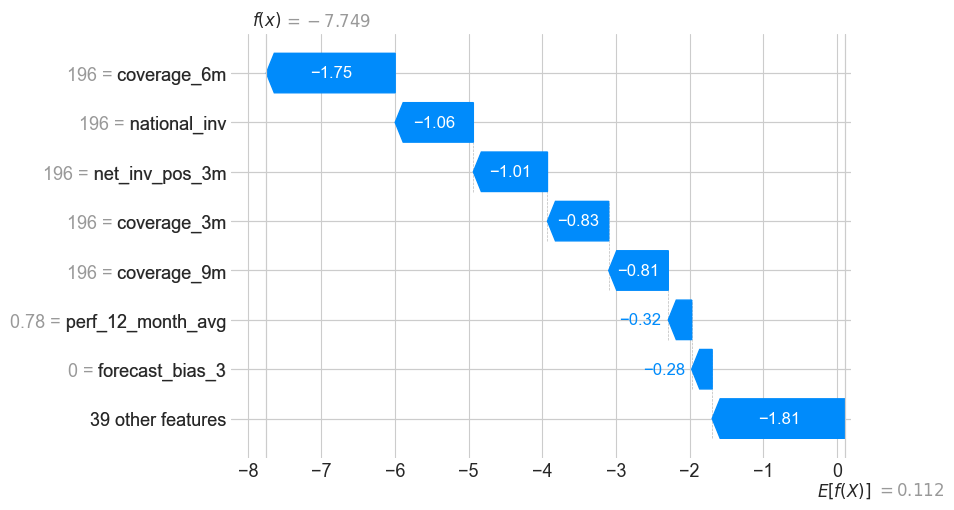

In [64]:
# waterfall plot
# picking one sample randomly
idx = X_shap.sample(1, random_state=42).index[0]
print('Chosen value:', idx)
# waterfall plot
plt.figure(figsize=(7, 4))
shap.plots.waterfall(
    shap.Explanation(
        values=shap_values[X_shap.index.get_loc(idx)],
        base_values=explainer.expected_value,
        data=X_shap.loc[idx],
        feature_names=X_shap.columns
    ),
    max_display=8
)
plt.show()


<div class="alert alert-block alert-warning">

**Waterfall plot intepretation:**
* plot explains the prediction for a single training observation (index = 237180) randomly selected
* starting from the model’s baseline expectation of backorder risk, this specific SKU is predicted to have a very low probability of backorder (-7.749)
* the largest downward contributions come from coverage-related features (coverage_6m, coverage_3m, and coverage_9m), indicating that inventory levels are more than sufficient relative to forecasted demand across multiple horizons.
* This effect is reinforced by a strong national inventory position and a positive net inventory position over three months, both of which substantially reduce risk.
* collectivelly, all the feature interact to produce a confident low-risk classification, demonstrating how the model integrates multiple supply-side buffers rather than relying on any single signal.

<div class="alert alert-block alert-info">

### 6. Evaluation
Using the XGBoost model to evaluate performance on the test set, as provided by Kaggle. The code below takes the test set through the same preprocessing steps i did earlier to make sure it is well-structured and in the appropriate format to be used for testing.

*Tip: this code takes a very long time to run (took me almost 20 mins), thus plan with caution*

In [57]:
# HOLDOUT TEST EVALUATION on df_test
# benchmark columns = X.columns - just for my reference
# X.columns

# 1) Start from raw test
df_test_eda = df_test.copy()

# apply SAME preprocessing as df_eda
# replace -99 with NaN
perf_cols = ["perf_6_month_avg", "perf_12_month_avg"]
for col in perf_cols:
    if col in df_test_eda.columns:
        df_test_eda[col] = df_test_eda[col].replace(-99, np.nan)

# missingness for lead_time
if "lead_time" in df_test_eda.columns:
    df_test_eda["lead_time_missing"] = df_test_eda["lead_time"].isna().astype(int)

# Yes/No to 1/0 flags
risk_flag_cols = ["potential_issue", "deck_risk", "oe_constraint", "ppap_risk", "stop_auto_buy", "rev_stop"]
for col in risk_flag_cols:
    if col in df_test_eda.columns:
        df_test_eda[col] = df_test_eda[col].map({"Yes": 1, "No": 0})

# encoding target to make sure i dont get the same error again
target = "went_on_backorder"
if target in df_test_eda.columns:
    df_test_eda[target] = df_test_eda[target].map({"Yes": 1, "No": 0})

# apply SAME feature engineering
df_test_fe = add_feature_engineering(df_test_eda)

# build X_test that matches training features EXACTLY
X_test = df_test_fe.reindex(columns=X.columns, fill_value=np.nan)
X_test = X_test.replace([np.inf, -np.inf], np.nan)

# for XGBoost, drop sku (since object column)
X_all_xgb  = X.drop(columns=["sku"], errors="ignore").replace([np.inf, -np.inf], np.nan)
X_test_xgb = X_test.drop(columns=["sku"], errors="ignore")

# retrain final XGBoost
neg, pos = np.bincount(y)
scale_pos_weight = neg / pos

final_xgb = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="aucpr",
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1
)
final_xgb.fit(X_all_xgb, y)
# predict
test_proba = final_xgb.predict_proba(X_test_xgb)[:, 1]
test_pred  = (test_proba >= 0.5).astype(int)

# eval
if target in df_test_fe.columns and df_test_fe[target].notna().any():
    y_test = df_test_fe[target]
    mask = y_test.notna()
    y_test = y_test[mask].astype(int)
    print("HOLDOUT TEST — XGBoost ROC-AUC:", round(roc_auc_score(y_test, test_proba[mask.values]), 4))
    print("HOLDOUT TEST — XGBoost PR-AUC :", round(average_precision_score(y_test, test_proba[mask.values]), 4))
    print("\nConfusion matrix:\n", confusion_matrix(y_test, test_pred[mask.values]))
    print("\nReport:\n", classification_report(y_test, test_pred[mask.values], digits=3))
else:
    print("No target found in dftest → produced predictions only.")
    print("test_proba and test_pred are ready.")


HOLDOUT TEST — XGBoost ROC-AUC: 0.8578
HOLDOUT TEST — XGBoost PR-AUC : 0.1459

Confusion matrix:
 [[238783    604]
 [  2368    320]]

Report:
               precision    recall  f1-score   support

           0      0.990     0.997     0.994    239387
           1      0.346     0.119     0.177      2688

    accuracy                          0.988    242075
   macro avg      0.668     0.558     0.586    242075
weighted avg      0.983     0.988     0.985    242075



<div class="alert alert-block alert-warning">

**Evaluation on test set interpretation**:
* **ROC-AUC = 0.858**: The model has good performance in separating high-risk vs low-risk items on unseen data
* **PR-AUC = 0.146**: Comparable to logistic regression validation
* The model generalises reasonably well but early-warning detection becomes harder under real-world distributions.

**Confusion matrix:**
* **True Negatives (238783)**: model correctly identifies the vast majority of non-backorder cases, meaning it has strong generalisation to unseen data.
* **False Positives (604)**: Very few non-backorders are incorrectly flagged
* **False Negatives (2368)**: *substantial number of true backorders are missed, showing that performance drops when moving from validation to truly unseen data*.
* **True Positives (320)**: successfully detects a meaningful subset of backorders but with reduced sensitivity compared to validation results.

**Classification report for both classes**:
* class 0: values confirm excellent performance on the majority class
    * Precision: 0.990
    * Recall: 0.997
    * F1-score: 0.994
* class 1
    * Precision: 0.346 - when the model predicts a backorder on unseen data, it is correct roughly 1/3 of the time.
    * Recall: 0.119 - only a small fraction of true backorders are identified, indicating reduced sensitivity on the hold-out set.
    * F1-score: 0.177 - Reflects the difficulty of detecting rare events under data distribution shift

**Conclusion: While XGBoost demonstrates strong overall discrimination and excellent performance on non-backorder cases, its ability to detect backorders decreases notably on the hold-out test set. This suggests that backorder risk patterns vary across time or product subsets, highlighting the inherent difficulty of generalising rare event prediction. Nevertheless, the model remains valuable as a risk-screening tool, where flagged items warrant closer inspection rather than automated action, and where false positives are less costly than missed backorders.**

<div class="alert alert-block alert-success">

## Bibliography

* Jenkins, A. (2025, March 20). How to manage Backorders. Oracle NetSuite. https://www.netsuite.com/portal/resource/articles/inventory-management/backorder.shtml
* Hand, R. (2025, July 14). Understanding service-level agreements (SLA) in ecommerce fulfilment logistics. ShipBob Australia. https://www.shipbob.com/au/blog/sla-service-level-agreement/#:~:text=1.,little%20room%20for%20misaligned%20expectations.
* What are supplier lead times and why they are important. Aligni. (2025, March 28). https://www.aligni.com/aligni-knowledge-center/what-are-supplier-lead-times-and-why-they-are-important/#:~:text=Supplier%20lead%20times%20refer%20to,associated%20with%20supply%20chain%20disruptions.
* Syntetos, A. A., Babai, M. Z., & Altay, N. (2012). (PDF) on the demand distributions of spare parts. ResearchGate. https://www.researchgate.net/publication/232924696_On_the_demand_distributions_of_spare_parts
* Foulis, D. (2021, March 29). What is PPAP and why is it important?. GRC Software Management Solutions. https://www.ideagen.com/thought-leadership/blog/what-is-ppap-and-why-is-it-important
* Team, S. (2025, March 31). The most important on-time delivery (OTD) metrics. https://sourceday.com/blog/on-time-delivery-metrics/

## APPENDIX

**Chat prompts used with ChatGPT:**

“can you explain what the variable coverage_6m represents in a supply-chain context and why it might be relevant for backorder prediction?”

“how should I interpret net_inv_pos_3m and how is it different from raw inventory levels?”

“what does forecast_bias_3 capture and how can forecast bias contribute to backorders?”

"what do the variables stop_auto_buy and rev_stop mean in this dataset"

"What are sensible ratio-based features to capture supply–demand balance and what is the range of the supply on-time ratio"

"coverage ratios and absolute inventory features in terms of backordering?"

"amongst the data fields i have (screenshot added), which variables do you think need to be dropped and why"

"what does zero inflation mean"

"explain data leakage in backorder prediction and what can be done to control it"

"why should the test set be used only once and can i try shap on it"

"how does logistic Regression, Random Forest, and XGBoost perform generally under strong class imbalance?"

"is PR-AUC better than ROC-AUC for rare-event prediction"

"How do I interpret a confusion matrix when false negatives are more costly than false positives (screenshot added)?"

"high-recall model vs high-precision model"

"how to interpret a SHAP summary plot versus a SHAP bar plot differently"

"what does SHAP dependence plot tell me about non-linear effects and feature interactions"

"do i need to redo the preprocessing in the exact same manner for my testing set"

"why does XGboost need nans dropped"

"what does coverage_6m actually mean in plain English, if it’s high or low, what does that tell me in operational terms"

"I’m thinking of creating ratios like inventory divided by forecast does that actually make sense or am I overengineering?”

"I get that SHAP shows feature importance, but what exactly is one dot in the beeswarm plot?"

"This preprocessing code is getting long should I turn it into a function"

"please help me clean and format my code in a presentable way (code attached)"